# Interconnect client churn

The telecom operator Interconnect would like to be able to forecast their churn of clients. If it's discovered that a user is planning to leave, Interconnect can offer promotional deals and special plan options to perhaps prevent the user from leaving their services. Based on current and past personal information of each client, including information about their plans and contracts, can machine learning assist in accurately predicting which users are close to discontinuing service? An acceptable model much yield an AUC-ROC of at least <font color='red'><b>0.75</font></b> to be promoted to production.

## Initialization

In [1]:
# Import libaries and modules
import pandas as pd
import numpy as np
from datetime import datetime as dt
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder, StandardScaler, power_transform
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, roc_auc_score
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
import lightgbm as lgb
import warnings

## Download data

In [2]:
# Convert csv files into pandas DataFrames
contract = pd.read_csv('/datasets/final_provider/contract.csv')
internet = pd.read_csv('/datasets/final_provider/internet.csv')
personal = pd.read_csv('/datasets/final_provider/personal.csv')
phone = pd.read_csv('/datasets/final_provider/phone.csv')

## Data preprocessing

Certain data preprocessing tasks were first performed, so the data was in the proper format for further analysis, feature engineering, and model building. The preprocessing tasks included:

- The <mark>contract</mark>, <mark>internet</mark>, <mark>personal</mark>, and <mark>phone</mark> DataFrames were merged into a single main Dataframe called <b><mark>data</mark></b>, so all the information pertaining to each customer was in one central location
    - There were two datasets that did not have as many records as the full dataset. This resulted in missing values after merging the four datasets. Thhese missing values were filled with the value of <b>Unknown</b>
- All column names were reformatted to lowercase lettering for consistency and simplicity
- The <b><mark>begindate</mark></b> data type was converted from object to datetime
    - The *day* information in the actual date did not provide any important or unique information since the day was always <b>01</b>. So, the day was removed from the date for simplicity and clean-up
- The <b><mark>totalcharges</mark></b> data type was converted from object to float64
    - There were 11 records in this field that contained just a space. Therefore, these one space string values were first replaced with the values in the <b><mark>monthlycharges</mark></b> column before converting the data type to float64

In [3]:
# Merge datasets into one DataFrame
# Fill in NA values with 'Unknown'
data = contract.merge(internet, on='customerID', how='outer').merge(personal, on='customerID', how='outer').merge(
       phone, on='customerID', how='outer').fillna('Unknown')
display(data.head())
print()
print(data.isna().sum())

customerID   BeginDate              EndDate            Type  \
0  7590-VHVEG  2020-01-01                   No  Month-to-month   
1  5575-GNVDE  2017-04-01                   No        One year   
2  3668-QPYBK  2019-10-01  2019-12-01 00:00:00  Month-to-month   
3  7795-CFOCW  2016-05-01                   No        One year   
4  9237-HQITU  2019-09-01  2019-11-01 00:00:00  Month-to-month   

  PaperlessBilling              PaymentMethod  MonthlyCharges TotalCharges  \
0              Yes           Electronic check           29.85        29.85   
1               No               Mailed check           56.95       1889.5   
2              Yes               Mailed check           53.85       108.15   
3               No  Bank transfer (automatic)           42.30      1840.75   
4              Yes           Electronic check           70.70       151.65   

  InternetService OnlineSecurity OnlineBackup DeviceProtection TechSupport  \
0             DSL             No          Yes               No          No   
1             DSL            Yes           No              Yes          No   
2             DSL            Yes          Yes               No          No   
3             DSL            Yes           No              Yes         Yes   
4     Fiber optic             No           No               No          No   

  StreamingTV StreamingMovies  gender  SeniorCitizen Partner Dependents  \
0          No              No  Female              0     Yes         No   
1          No              No    Male              0      No         No   
2          No              No    Male              0      No         No   
3          No              No    Male              0      No         No   
4          No              No  Female              0      No         No   

  MultipleLines  
0       Unknown  
1            No  
2            No  
3       Unknown  
4            No


customerID          0
BeginDate           0
EndDate             0
Type                0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
MultipleLines       0
dtype: int64


In [4]:
# Update columns to all lowercase lettering
data.columns = data.columns.str.lower()
print(data.columns)

Index(['customerid', 'begindate', 'enddate', 'type', 'paperlessbilling',
       'paymentmethod', 'monthlycharges', 'totalcharges', 'internetservice',
       'onlinesecurity', 'onlinebackup', 'deviceprotection', 'techsupport',
       'streamingtv', 'streamingmovies', 'gender', 'seniorcitizen', 'partner',
       'dependents', 'multiplelines'],
      dtype='object')


In [5]:
# Convert data type to datetime for the begindate field - remove day information
data['begindate'] = pd.to_datetime(data['begindate'], format='%Y-%m-%d').dt.to_period('M')

# Replace one space records in the totalcharges field
print('Number of one space values:', data.query("totalcharges == ' '").count()['totalcharges'])
print
data['totalcharges'] = np.where(data['totalcharges'] == ' ', data['monthlycharges'], data['totalcharges'])
print('Number of one space values after replacement:', data.query("totalcharges == ' '").count()['totalcharges'])
print()
print('------------------------------------------------')
print()

# Convert data type to float64 for the totalcharges field
data['totalcharges'] = data['totalcharges'].astype('float64')

# Confirm data type changes
print(data[['begindate', 'totalcharges']].dtypes)
display(data.head())

Number of one space values: 11
Number of one space values after replacement: 0

------------------------------------------------

begindate       period[M]
totalcharges      float64
dtype: object


customerid begindate              enddate            type paperlessbilling  \
0  7590-VHVEG   2020-01                   No  Month-to-month              Yes   
1  5575-GNVDE   2017-04                   No        One year               No   
2  3668-QPYBK   2019-10  2019-12-01 00:00:00  Month-to-month              Yes   
3  7795-CFOCW   2016-05                   No        One year               No   
4  9237-HQITU   2019-09  2019-11-01 00:00:00  Month-to-month              Yes   

               paymentmethod  monthlycharges  totalcharges internetservice  \
0           Electronic check           29.85         29.85             DSL   
1               Mailed check           56.95       1889.50             DSL   
2               Mailed check           53.85        108.15             DSL   
3  Bank transfer (automatic)           42.30       1840.75             DSL   
4           Electronic check           70.70        151.65     Fiber optic   

  onlinesecurity onlinebackup deviceprotection techsupport streamingtv  \
0             No          Yes               No          No          No   
1            Yes           No              Yes          No          No   
2            Yes          Yes               No          No          No   
3            Yes           No              Yes         Yes          No   
4             No           No               No          No          No   

  streamingmovies  gender  seniorcitizen partner dependents multiplelines  
0              No  Female              0     Yes         No       Unknown  
1              No    Male              0      No         No            No  
2              No    Male              0      No         No            No  
3              No    Male              0      No         No       Unknown  
4              No  Female              0      No         No            No

## Exploratory data analysis

### Client churn progression

How has client churn changed over time? Are customers starting to leave more recently, or has churn been more of a past issue? How frequent do customers discontinue service? Is the number of new customers that join increasing over time? Answers to these questions can help us better understand the influx and outflux of customers in relation to time, and it is one type of measuring pole that describes the overall health of the company. Are there more new customers than customers leaving?

In [6]:
# Create a DataFrame copy 
data_copy = data.copy()

# Convert begindate to a string
data_copy['begindate'] = data_copy['begindate'].astype('str')
data_copy = data_copy.sort_values('begindate')

'''I was receiving errors with the data type being datetime when plotting the histogram.
For that reason, just for EDA, the 'begindate' field was converted back to a string data type.'''

# Create a DataFrame copy 
data_copy2 = data.copy()

# Filter for clients that have left the company and slice the data to only include year and month
data_copy2 = data_copy2[data_copy2['enddate'] != 'No']
data_copy2['enddate'] = data_copy2['enddate'].str[:7]
data_copy2 = data_copy2.sort_values('enddate')

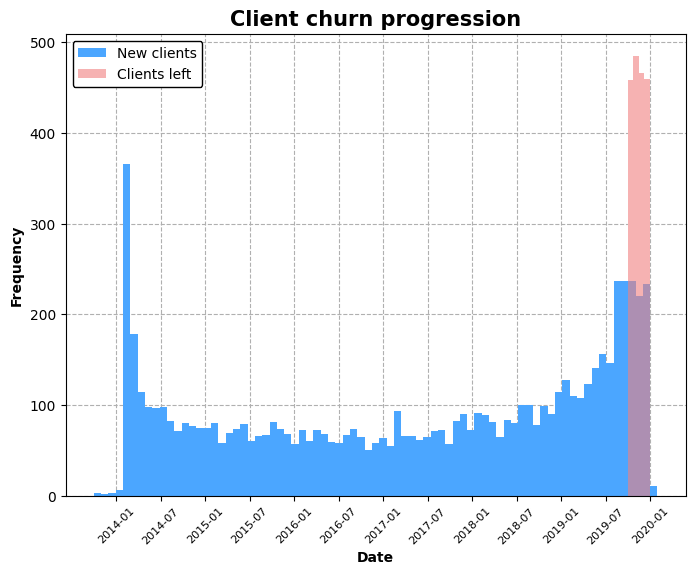

In [7]:
# Create plot figure and subplot
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111)

# Create histograms
ax.hist(data_copy['begindate'], color='white', bins=len(set(data_copy['begindate'])))
ax.hist(data_copy2['enddate'], color='white', bins=len(set(data_copy2['enddate'])))
ax.hist(data_copy['begindate'], label='New clients', bins=len(set(data_copy['begindate'])), alpha=0.8, color='dodgerblue')
ax.hist(data_copy2['enddate'], label='Clients left', bins=len(set(data_copy2['enddate'])), alpha=0.6, color='lightcoral')

'''The axis gridlines in charts still show up under the histogram bins when there is an alpha value less than 1. 
It's a personal preference to not have the gridlines appear crossing all the bins. To rid this, two white histograms 
were added which cover the gridlines, and the actual histograms with color overlay the white "dummies".'''

# Add grid and set below figure
ax.grid(True, axis='both', linestyle='dashed')
ax.set_axisbelow(True)

# Add legend and labels
plt.legend(facecolor='white', framealpha=1, loc='upper left', edgecolor='black')
plt.title('Client churn progression', fontsize=15, fontweight='bold')
plt.xlabel('Date', fontweight='bold')
x_positions = [3, 9, 15, 21, 27, 33, 39, 45, 51, 57, 63, 69, 75]
x_labels = ['2014-01', '2014-07', '2015-01', '2015-07', '2016-01', '2016-07', '2017-01', '2017-07', '2018-01', 
            '2018-07', '2019-01', '2019-07', '2020-01']
ax.set_xticks(x_positions)
ax.set_xticklabels(x_labels)
plt.xticks(fontsize=8, rotation=45)
plt.ylabel('Frequency', fontweight='bold')
plt.show()

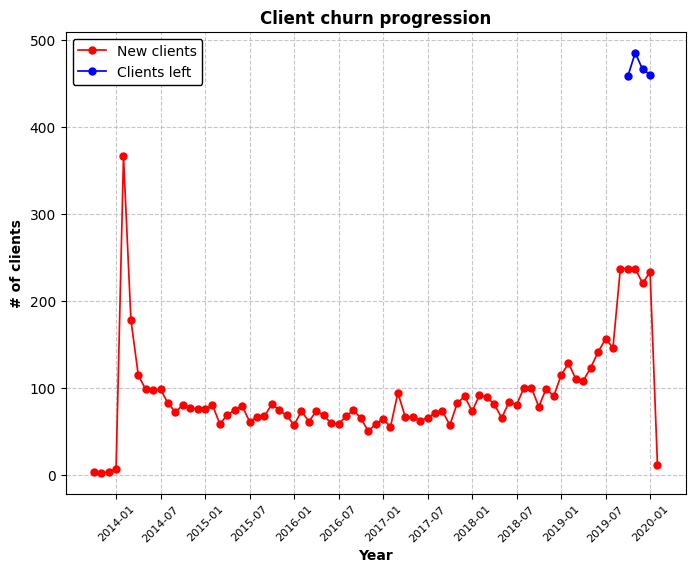

In [8]:
# Get value counts
begin_date_counts = data_copy['begindate'].value_counts()
end_date_counts = data_copy2['enddate'].value_counts()

# Reorganize value counts DataFrames
begin_date_counts = begin_date_counts.reset_index().rename(columns={'index': 'Date', 'begindate': 'Count'}).sort_values('Date').reset_index(drop=True)
end_date_counts = end_date_counts.reset_index().rename(columns={'index': 'Date', 'enddate': 'Count'}).sort_values('Date').reset_index(drop=True)

# Create plot figure and subplot
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111)

# Plot counts on a line chart
plt.plot(begin_date_counts['Date'], begin_date_counts['Count'], label='New clients', color='red', marker='o', 
         markersize=5, linewidth=1.25)
plt.plot(end_date_counts['Date'], end_date_counts['Count'], label='Clients left', color='blue', marker='o', 
         markersize=5, linewidth=1.25)

# Set title, axis labels, and tick information
plt.legend(facecolor='white', framealpha=1, loc='upper left', edgecolor='black')
plt.title('Client churn progression', fontweight='bold')
plt.xlabel('Year', fontweight='bold')
x_positions = [3, 9, 15, 21, 27, 33, 39, 45, 51, 57, 63, 69, 75]
x_labels = ['2014-01', '2014-07', '2015-01', '2015-07', '2016-01', '2016-07', '2017-01', '2017-07', '2018-01', 
            '2018-07', '2019-01', '2019-07', '2020-01']
ax.set_xticks(x_positions)
ax.set_xticklabels(x_labels)
plt.xticks(fontsize=8, rotation=45)
plt.ylabel('# of clients', fontweight='bold')

# Add gridlines to chart
plt.grid(axis='both', linestyle='--', alpha=0.7)
plt.gca().set_axisbelow(True)

# Display results
plt.show()

<b>Conclusions</b>

Each graph provides a different look of client churn over the years, but both graphs tell the same story. Interconnect did not experience any clients discontinuing service for the first 6 years. This could either be because clients loved their services and did not want to leave or this data was just not collected during this time.

There is an abrupt spike in new customers the past year, from 2019-07 to 2020-01. But very interestingly, the amount of clients that left <b>skyrocketed</b>. Interconnect experienced it's highest peak of new customers since 2014 during this time period, but it also saw many customers leaving. Over 450 clients left per month the past 4 months. Moreover, even with the spike in new customers, there was still a net loss of around <b><font color='red'>-200</font></b> customers in the past 4 months.

### Client tenure distribution

The fact that so many customers have left in recent months made looking at client tenure a natural next step in the analysis. Out of the customers that left, were they customers that joined recently and just did not like the services offered, or does it also include loyal customers who have had the services for a long time? Because the customers that left all left during the same time (past 4 months), looking at the tenure of past clients can help answer these questions. 

In [9]:
# Create a DataFrame copy 
data_copy = data.copy()

# Filter for clients that have left the company
data_copy['discontinued'] = ''
data_copy.loc[data_copy['enddate'] == 'No', 'discontinued'] = 'No'
data_copy.loc[data_copy['enddate'] != 'No', 'discontinued'] = 'Yes'
data_copy_churn = data_copy[data_copy['discontinued'] == 'Yes']

# Slice the data to only include year and month
warnings.filterwarnings('ignore')
data_copy_churn['enddate'] = data_copy_churn['enddate'].str[:7]

# Convert enddate field to datetime / period data type
data_copy_churn['enddate'] = pd.to_datetime(data_copy_churn['enddate'], format='%Y-%m-%d').dt.to_period('M')

# Create tenure field
data_copy_churn['tenure'] = (data_copy_churn['enddate'] - data_copy_churn['begindate']).apply(lambda x: x.n)

# Get value counts
tenure_counts = data_copy_churn['tenure'].value_counts().reset_index().rename(columns={'index': 'count'})
display(tenure_counts)

count  tenure
0       1     380
1       2     123
2       3      94
3       4      83
4       5      64
..    ...     ...
67     71       6
68     72       6
69     62       5
70     63       4
71     64       4

[72 rows x 2 columns]

Text(0, 0.5, 'Client count')

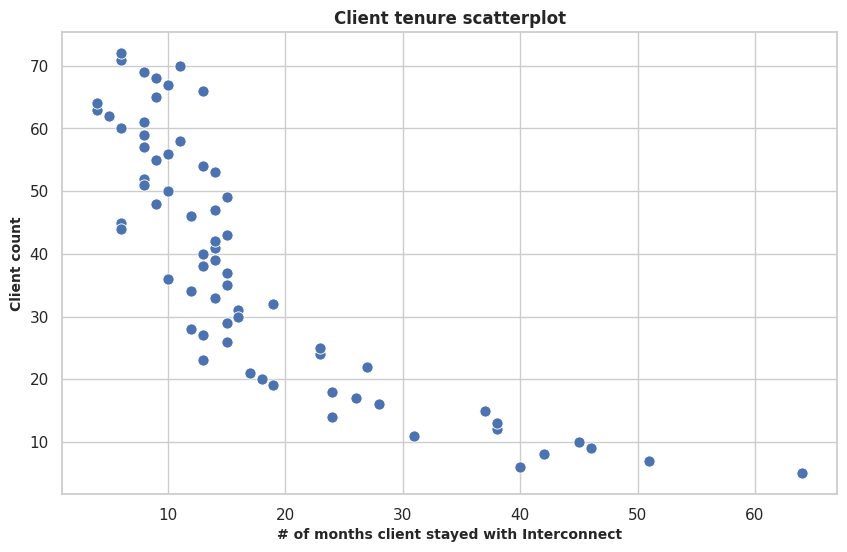

In [10]:
# Remove outliers
tenure_counts_update = tenure_counts.copy()
tenure_counts_update = tenure_counts_update[4:].reset_index(drop=True)

'''The first 4 records had tenures way above the rest of the records. This made the scatterplot more 
difficult to interpret. So, for the scatterplot, and other EDA, these values were removed.'''

# Create scatterplot of tenure counts
plt.figure(figsize=(10, 6))
sns.set(style='whitegrid')
sns.scatterplot(data=tenure_counts_update, x='tenure', y='count', s=65)

# Add title and labels
plt.title('Client tenure scatterplot', fontweight='bold')
plt.xlabel('# of months client stayed with Interconnect', fontsize=10, fontweight='bold')
plt.ylabel('Client count', fontsize=10, fontweight='bold')

This chart displays the count of each tenure amount (in months). For example, for the data point farthest to the right, there were 5 customers that had a tenure of 64 months.

<b>NOTE</b>: Customers that had tenures of over 80 months were considered outliers for visualization purposes. The charts were much more interpretable with these removed. There were 4 records with a tenure over 80 months.

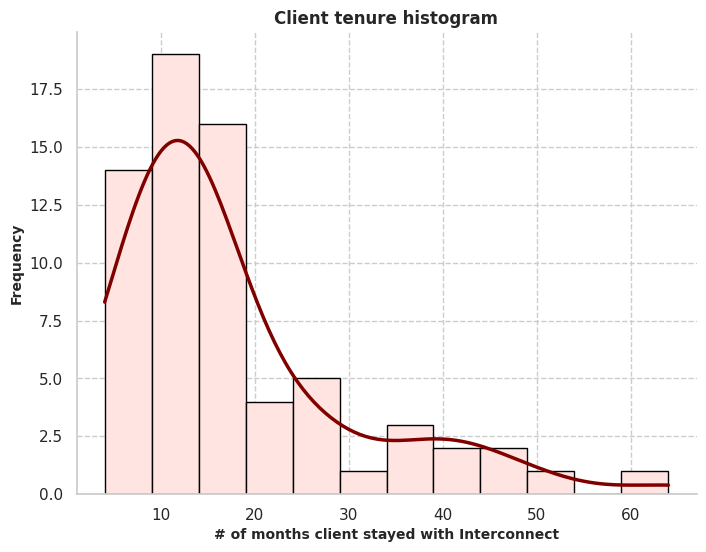

In [11]:
# Plot figure and axis
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111)

# Create histogram of tenure counts
sns.histplot(data=tenure_counts_update, x='tenure', alpha=1.0, color='mistyrose', edgecolor='black', kde=True)

# Change color of kde line
ax.lines[0].set_color('maroon')
ax.lines[0].set_linewidth(2.5)

# Add title and labels
plt.title('Client tenure histogram', fontweight='bold')
plt.xlabel('# of months client stayed with Interconnect', fontsize=10, fontweight='bold')
plt.ylabel('Frequency', fontsize=10, fontweight='bold')

# Add gridlines
sns.despine()
ax.grid(True, axis='both', linestyle='dashed')
ax.set_axisbelow(True)

# Display plot
plt.show()

In [12]:
tenure_percent = ((tenure_counts[tenure_counts['tenure'] <= 24].count()['tenure']) / len(tenure_counts) * 100).round(2)
print('Percentage of customers that left within 2 years:', tenure_percent, '%')

Percentage of customers that left within 2 years: 76.39 %


<b>Conclusions</b>

Both graphs indicate that out of the customers that have left Interconnect, a vast majority of them were newer customers. Over <b><font color='red'>76%</font></b> of the customers had a tenure of 24 months or less. Since the data in the first two charts indicated that customers have only left very recently (past 4 months), the results from both charts here means that customers who joined Interconnect within the last 2 years soon left and discontinued service. Only <b><font color='red'>24%</font></b> of what would be considered longer-tenured or loyal customers have left in recent months. 

### Client characteristics and churn

Analyzing certain characteristics of each client could reveal patterns that result in client churn. Here, <b>gender</b> and <b>seniority</b> (senior citizen) are examined. Males vs females, senior citizens vs not senior citizens, could have different preferences in services, so promotional deals and plan options could be tailored around what each group enjoys, has services of, etc.

#### Gender

gender discontinued  count
0  Female           No   2549
1  Female          Yes    939
2    Male           No   2625
3    Male          Yes    930

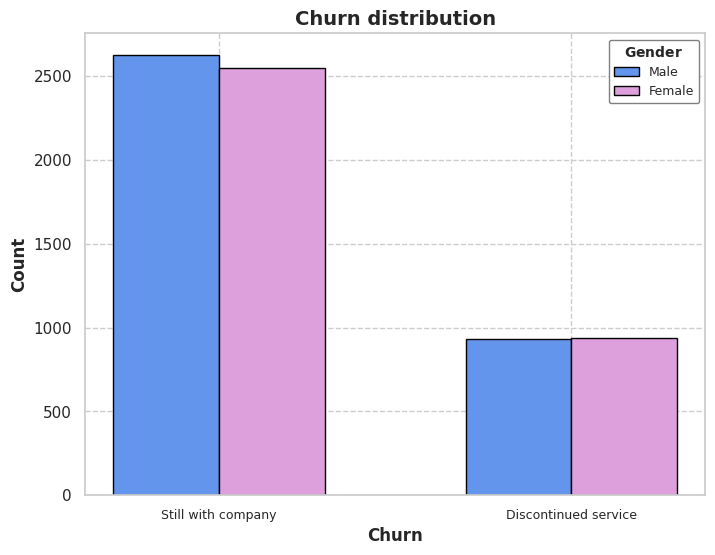

In [13]:
# Get value counts of gender field
churn_gender_group = data_copy.groupby(['gender', 'discontinued']).count()['customerid'].reset_index().rename(columns={'customerid': 'count'})
display(churn_gender_group)

# Create plot figure and subplot
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111)

# Create labels and x axis position
x = np.arange(2)
xlabels = ['Still with company', 'Discontinued service']
xpositions = [0, 1]
width = 0.30

# Plot bar chart
plt.bar(x-0.15, churn_gender_group['count'].iloc[2:4], width, color='cornflowerblue', edgecolor='black')
plt.bar(x+0.15, churn_gender_group['count'].iloc[0:2], width, color='plum', edgecolor='black')

# Add title, axis labels, and legend
plt.title('Churn distribution', fontsize=14, fontweight='bold')
plt.xlabel('Churn', fontweight='bold')
plt.ylabel('Count', fontweight='bold')
plt.xticks(xpositions, xlabels, fontsize=9)
plt.legend(title=r'$\bf{Gender}$', title_fontsize=10, fontsize=9, labels=['Male', 'Female'], loc='upper right', 
           framealpha=1.0, edgecolor='gray')

# Add grid and set below figure
ax.grid(True, axis='both', linestyle='dashed')
ax.set_axisbelow(True)

# Display chart
plt.show()

In [14]:
# Identify bins and bin labels
bins = [0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80]
labels = ['0-5', '5-10', '10-15', '15-20', '20-25', '25-30', '30-35', '35-40', '40-45', '45-50', '50-55', '55-60', '60-65', 
          '65-70', '70-75', '75-80']

# Create tenure_bin column
data_copy_churn['tenure_bin'] = pd.cut(data_copy_churn['tenure'], bins=bins, labels=labels)

# Group by gender and tenure_bin fields
gender_tenure_group = data_copy_churn.groupby(['gender', 'tenure_bin']).count()['tenure'].reset_index()

# Reorganize DataFrame by moving certain rows (male rows) into columns
select_rows = gender_tenure_group.iloc[16:]
gender_tenure_group = gender_tenure_group.drop(gender_tenure_group.index[16:])
gender_tenure_group = gender_tenure_group.merge(select_rows, on='tenure_bin', how='inner').rename(columns={
    'gender_x': 'gender_female', 'tenure_bin': 'tenure_bin', 'tenure_x': 'tenure_female', 'gender_y': 'gender_male', 
    'tenure_y': 'tenure_male'}).reindex(columns=['tenure_bin', 'gender_female', 'tenure_female', 'gender_male', 
                                                 'tenure_male'])

# Create tenure_total, female%, and male% columns
gender_tenure_group['tenure_total'] = gender_tenure_group['tenure_female'] + gender_tenure_group['tenure_male']
gender_tenure_group['female%'] = ((gender_tenure_group['tenure_female'] / gender_tenure_group['tenure_total']) * 100).round(2)
gender_tenure_group['male%'] = ((gender_tenure_group['tenure_male'] / gender_tenure_group['tenure_total']) * 100).round(2)

# Remove irrelevant columns
gender_tenure_group = gender_tenure_group.drop(['gender_female', 'gender_male'], axis=1)

# Display DataFrame
display(gender_tenure_group)

tenure_bin  tenure_female  tenure_male  tenure_total  female%  male%
0         0-5            382          362           744    51.34  48.66
1        5-10            110          114           224    49.11  50.89
2       10-15             96           72           168    57.14  42.86
3       15-20             56           59           115    48.70  51.30
4       20-25             44           59           103    42.72  57.28
5       25-30             42           29            71    59.15  40.85
6       30-35             41           35            76    53.95  46.05
7       35-40             34           31            65    52.31  47.69
8       40-45             29           26            55    52.73  47.27
9       45-50             31           29            60    51.67  48.33
10      50-55             20           32            52    38.46  61.54
11      55-60             18           25            43    41.86  58.14
12      60-65             15           15            30    50.00  50.00
13      65-70             17           34            51    33.33  66.67
14      70-75              4            8            12    33.33  66.67
15      75-80              0            0             0      NaN    NaN

This table groups customers based on gender and puts each customer into a tenure bin. For example, for index 0, the tenure bin is 0-5, meaning that customers in this bin stayed with Interconnect for only 0 to 5 months. Then, there are percentages for each gender representing the percentage of males and females out of all customers from each bin.

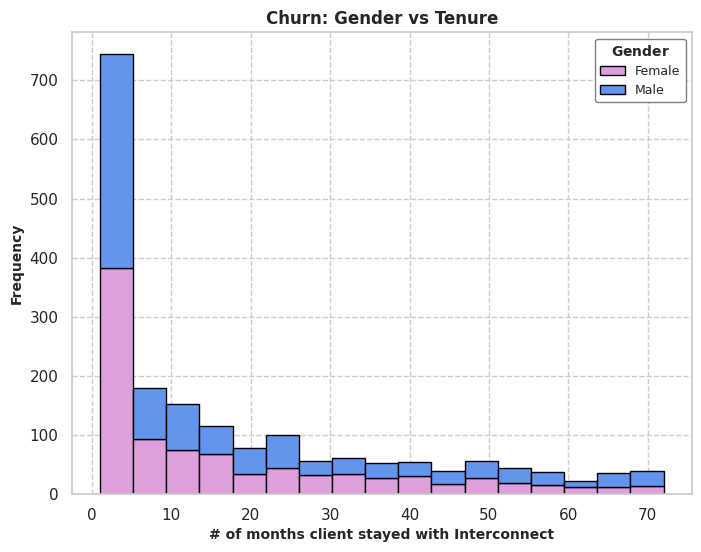

In [15]:
# Plot figure and axis
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111)

# Create histogram of tenure counts
color_dict = {'Female': 'plum', 'Male': 'cornflowerblue'}
sns.histplot(data=data_copy_churn, x='tenure', alpha=1.0, bins=17, hue='gender', palette=color_dict, multiple='stack', legend=False, 
             edgecolor='black')

# Add title, labels, and legend
plt.title('Churn: Gender vs Tenure', fontweight='bold')
plt.xlabel('# of months client stayed with Interconnect', fontsize=10, fontweight='bold')
plt.ylabel('Frequency', fontsize=10, fontweight='bold')
plt.legend(title=r'$\bf{Gender}$', title_fontsize=10, fontsize=9, labels=['Female', 'Male'], loc='upper right', 
           framealpha=1.0, edgecolor='gray')

# Add gridlines
ax.grid(True, axis='both', linestyle='dashed')
ax.set_axisbelow(True)

# Display plot
plt.show()

In [16]:
# Create columns varibale and empty gender lists
columns = ['internetservice', 'onlinesecurity', 'onlinebackup', 'deviceprotection', 'techsupport', 'streamingtv', 
           'streamingmovies']
male_counts = []
female_counts = []

# Create a loop that calculates the total count for each service by gender
for col in data_copy_churn[columns]:
    if col == 'internetservice':
        male_count_DSL = data_copy_churn[(data_copy_churn['gender'] == 'Male') & (data_copy_churn[col] == 'DSL')].count()[col]
        male_counts.append(male_count_DSL)
        male_count_fo = data_copy_churn[(data_copy_churn['gender'] == 'Male') & (data_copy_churn[col] == 'Fiber optic')].count()[col]
        male_counts.append(male_count_fo)
        female_count_DSL = data_copy_churn[(data_copy_churn['gender'] == 'Female') & (data_copy_churn[col] == 'DSL')].count()[col]
        female_counts.append(female_count_DSL)
        female_count_fo = data_copy_churn[(data_copy_churn['gender'] == 'Female') & (data_copy_churn[col] == 'Fiber optic')].count()[col]
        female_counts.append(female_count_fo)
    else:
        male_count = data_copy_churn[(data_copy_churn['gender'] == 'Male') & (data_copy_churn[col] == 'Yes')].count()[col]
        male_counts.append(male_count)
        female_count = data_copy_churn[(data_copy_churn['gender'] == 'Female') & (data_copy_churn[col] == 'Yes')].count()[col]
        female_counts.append(female_count)

print('Interconnect service counts for Male customers that discontinued:', male_counts)
print('Total count of all servies for Male customers that discontinued:', sum(male_counts))
print('Interconnect service counts for Female customers that discontinued:', female_counts)
print('Total count of all servies for Female customers that discontinued:', sum(female_counts))

Interconnect service counts for Male customers that discontinued: [240, 633, 133, 258, 278, 145, 412, 411]
Total count of all servies for Male customers that discontinued: 2510
Interconnect service counts for Female customers that discontinued: [219, 664, 162, 265, 267, 165, 402, 407]
Total count of all servies for Female customers that discontinued: 2551


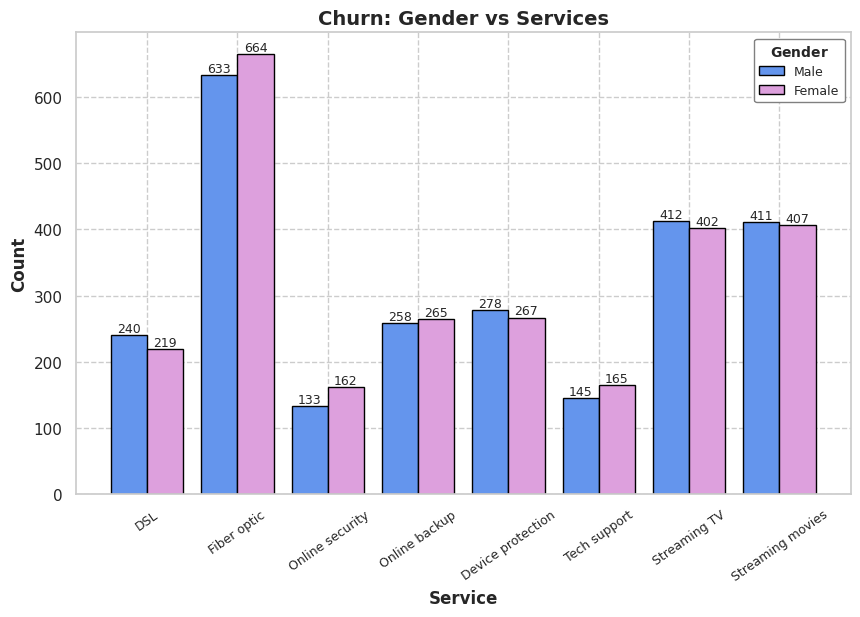

In [17]:
# Create plot figure and subplot
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111)

# Create labels and x axis position
x = np.arange(8)
xlabels = ['DSL', 'Fiber optic', ' Online security', 'Online backup', 'Device protection', 'Tech support', 'Streaming TV', 
           'Streaming movies']
xpositions = [0, 1, 2, 3, 4, 5, 6, 7]
width = 0.40

# Plot bar chart
plt.bar(x-0.2, male_counts, width, color='cornflowerblue', edgecolor='black')
plt.bar(x+0.2, female_counts, width, color='plum', edgecolor='black')

# Add title, axis labels, and legend
plt.title('Churn: Gender vs Services', fontsize=14, fontweight='bold')
plt.xlabel('Service', fontweight='bold')
plt.ylabel('Count', fontweight='bold')
plt.xticks(xpositions, xlabels, rotation=35, fontsize=9)
plt.legend(title=r'$\bf{Gender}$', title_fontsize=10, fontsize=9, labels=['Male', 'Female'], loc='upper right', 
           framealpha=1.0, edgecolor='gray')

# Add counts on top of each bar
for i in range(len(xlabels)):
    plt.text(i-0.2, male_counts[i], male_counts[i], fontsize=9, ha='center', va='bottom')
    plt.text(i+0.2, female_counts[i], female_counts[i], fontsize=9, ha='center', va='bottom')
    
# Add grid and set below figure
ax.grid(True, axis='both', linestyle='dashed')
ax.set_axisbelow(True)

# Display chart
plt.show()

<b>Conclusions</b>

Overall there were not many differences in churn or service preferences between male and female genders. First, counts of males that discontinued service vs stayed with the company were nearly identical to that of females. There was no indication that more males have discontinued service than females. The tenure of males vs females, that is out of customers that discontinued service, how long did each gender stay with the company, was also very similar. Lastly, the types of services that each gender preferred was similar as well, as displayed in the chart above. There are no obvious differences in churn, tenure, or service preferences between both genders.

#### Senior citizen

seniorcitizen discontinued  count
0              0           No   4508
1              0          Yes   1393
2              1           No    666
3              1          Yes    476

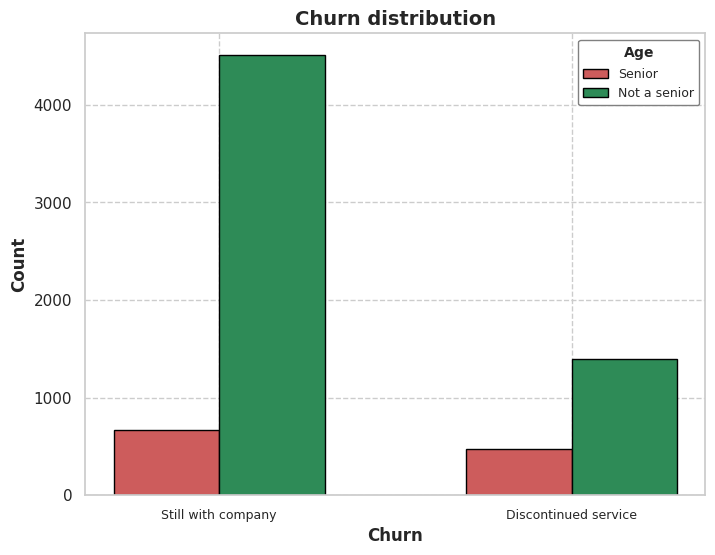

In [18]:
# Get value counts of seniorcitizen field
churn_senior_group = data_copy.groupby(['seniorcitizen', 'discontinued']).count()['customerid'].reset_index().rename(columns={'customerid': 'count'})
display(churn_senior_group)

# Create plot figure and subplot
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111)

# Create labels and x axis position
x = np.arange(2)
xlabels = ['Still with company', 'Discontinued service']
xpositions = [0, 1]
width = 0.30

# Plot bar chart
plt.bar(x-0.15, churn_senior_group['count'].iloc[2:4], width, color='indianred', edgecolor='black')
plt.bar(x+0.15, churn_senior_group['count'].iloc[0:2], width, color='seagreen', edgecolor='black')

# Add title, axis labels, and legend
plt.title('Churn distribution', fontsize=14, fontweight='bold')
plt.xlabel('Churn', fontweight='bold')
plt.ylabel('Count', fontweight='bold')
plt.xticks(xpositions, xlabels, fontsize=9)
plt.legend(title=r'$\bf{Age}$', title_fontsize=10, fontsize=9, labels=['Senior', 'Not a senior'], 
           loc='upper right', framealpha=1.0, edgecolor='gray')

# Add grid and set below figure
ax.grid(True, axis='both', linestyle='dashed')
ax.set_axisbelow(True)

# Display chart
plt.show()

In [19]:
# Identify bins and bin labels
bins = [0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80]
labels = ['0-5', '5-10', '10-15', '15-20', '20-25', '25-30', '30-35', '35-40', '40-45', '45-50', '50-55', '55-60', '60-65', 
          '65-70', '70-75', '75-80']

# Create tenure_bin column
data_copy_churn['tenure_bin'] = pd.cut(data_copy_churn['tenure'], bins=bins, labels=labels)

# Group by gender and tenure_bin fields
senior_tenure_group = data_copy_churn.groupby(['seniorcitizen', 'tenure_bin']).count()['tenure'].reset_index()

# Reorganize DataFrame by moving certain rows (male rows) into columns
select_rows = senior_tenure_group.iloc[16:]
senior_tenure_group = senior_tenure_group.drop(senior_tenure_group.index[16:])
senior_tenure_group = senior_tenure_group.merge(select_rows, on='tenure_bin', how='inner').rename(columns={
    'seniorcitizen_x': 'senior_no', 'tenure_bin': 'tenure_bin', 'tenure_x': 'senior_no_count', 
    'seniorcitizen_y': 'senior_yes', 'tenure_y': 'senior_yes_count'}).reindex(columns=['tenure_bin', 'senior_no', 
                                                                                       'senior_no_count', 'senior_yes', 'senior_yes_count'])

# Create tenure_total, female%, and male% columns
senior_tenure_group['tenure_total'] = senior_tenure_group['senior_no_count'] + senior_tenure_group['senior_yes_count']
senior_tenure_group['senior_yes%'] = ((senior_tenure_group['senior_no_count'] / senior_tenure_group['tenure_total']) * 100).round(2)
senior_tenure_group['senior_no%'] = ((senior_tenure_group['senior_yes_count'] / senior_tenure_group['tenure_total']) * 100).round(2)

# Remove irrelevant columns
senior_tenure_group = senior_tenure_group.drop(['senior_no', 'senior_yes'], axis=1)

# Display DataFrame
display(senior_tenure_group)

tenure_bin  senior_no_count  senior_yes_count  tenure_total  senior_yes%  \
0         0-5              592               152           744        79.57   
1        5-10              173                51           224        77.23   
2       10-15              126                42           168        75.00   
3       15-20               80                35           115        69.57   
4       20-25               76                27           103        73.79   
5       25-30               41                30            71        57.75   
6       30-35               53                23            76        69.74   
7       35-40               42                23            65        64.62   
8       40-45               36                19            55        65.45   
9       45-50               39                21            60        65.00   
10      50-55               36                16            52        69.23   
11      55-60               30                13            43        69.77   
12      60-65               25                 5            30        83.33   
13      65-70               35                16            51        68.63   
14      70-75                9                 3            12        75.00   
15      75-80                0                 0             0          NaN   

    senior_no%  
0        20.43  
1        22.77  
2        25.00  
3        30.43  
4        26.21  
5        42.25  
6        30.26  
7        35.38  
8        34.55  
9        35.00  
10       30.77  
11       30.23  
12       16.67  
13       31.37  
14       25.00  
15         NaN

This table groups customers based on seniority and puts each customer into a tenure bin. For example, for index 0, the tenure bin is 0-5, meaning that customers in this bin stayed with Interconnect for only 0 to 5 months. Then, there are percentages based on seniority representing the percentage of seniors and non-seniors out of all customers from each bin.

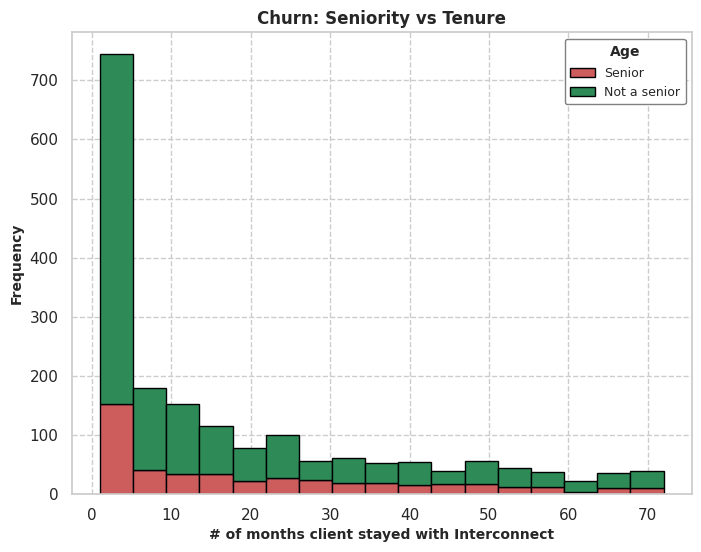

In [20]:
# Plot figure and axis
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111)

# Create histogram of tenure counts
color_dict = {1: 'indianred', 0: 'seagreen'}
sns.histplot(data=data_copy_churn, x='tenure', alpha=1.0, bins=17, hue='seniorcitizen', palette=color_dict, multiple='stack', legend=False, 
             edgecolor='black')

# Add title, labels, and legend
plt.title('Churn: Seniority vs Tenure', fontweight='bold')
plt.xlabel('# of months client stayed with Interconnect', fontsize=10, fontweight='bold')
plt.ylabel('Frequency', fontsize=10, fontweight='bold')
plt.legend(title=r'$\bf{Age}$', title_fontsize=10, fontsize=9, labels=['Senior', 'Not a senior'], loc='upper right', 
           framealpha=1.0, edgecolor='gray')

# Add gridlines
ax.grid(True, axis='both', linestyle='dashed')
ax.set_axisbelow(True)

# Display plot
plt.show()

In [21]:
# Create columns varibale and empty gender lists
columns = ['internetservice', 'onlinesecurity', 'onlinebackup', 'deviceprotection', 'techsupport', 'streamingtv', 
           'streamingmovies']
senior_counts = []
no_senior_counts = []

# Create a loop that calculates the total count for each service by gender
for col in data_copy_churn[columns]:
    if col == 'internetservice':
        senior_DSL = data_copy_churn[(data_copy_churn['seniorcitizen'] == 1) & (data_copy_churn[col] == 'DSL')].count()[col]
        senior_counts.append(senior_DSL)
        senior_fo = data_copy_churn[(data_copy_churn['seniorcitizen'] == 1) & (data_copy_churn[col] == 'Fiber optic')].count()[col]
        senior_counts.append(senior_fo)
        no_senior_DSL = data_copy_churn[(data_copy_churn['seniorcitizen'] == 0) & (data_copy_churn[col] == 'DSL')].count()[col]
        no_senior_counts.append(no_senior_DSL)
        no_senior_fo = data_copy_churn[(data_copy_churn['seniorcitizen'] == 0) & (data_copy_churn[col] == 'Fiber optic')].count()[col]
        no_senior_counts.append(no_senior_fo)
    else:
        senior_count = data_copy_churn[(data_copy_churn['seniorcitizen'] == 1) & (data_copy_churn[col] == 'Yes')].count()[col]
        senior_counts.append(senior_count)
        no_senior_count = data_copy_churn[(data_copy_churn['seniorcitizen'] == 0) & (data_copy_churn[col] == 'Yes')].count()[col]
        no_senior_counts.append(no_senior_count)

print('Interconnect service counts for senior citizens that discontinued:', senior_counts)
print('Total count of all servies for senior citizens that discontinued:', sum(senior_counts))
print('Interconnect service counts for non-senior citizens that discontinued:', no_senior_counts)

Interconnect service counts for senior citizens that discontinued: [78, 393, 64, 147, 151, 51, 229, 244]
Total count of all servies for senior citizens that discontinued: 1357
Interconnect service counts for non-senior citizens that discontinued: [381, 904, 231, 376, 394, 259, 585, 574]


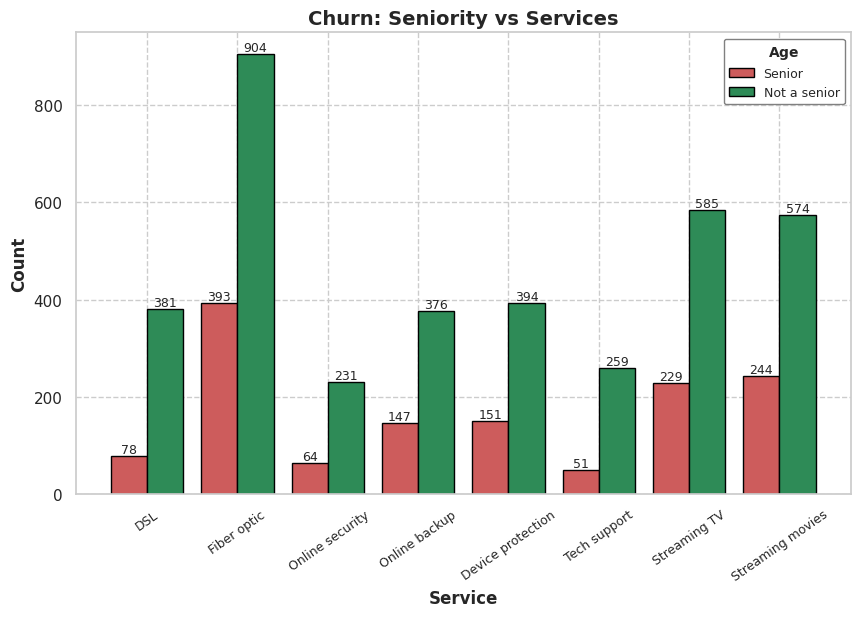

In [22]:
# Create plot figure and subplot
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111)

# Create labels and x axis position
x = np.arange(8)
xlabels = ['DSL', 'Fiber optic', ' Online security', 'Online backup', 'Device protection', 'Tech support', 'Streaming TV', 
           'Streaming movies']
xpositions = [0, 1, 2, 3, 4, 5, 6, 7]
width = 0.40

# Plot bar chart
plt.bar(x-0.2, senior_counts, width, color='indianred', edgecolor='black')
plt.bar(x+0.2, no_senior_counts, width, color='seagreen', edgecolor='black')

# Add title, axis labels, and legend
plt.title('Churn: Seniority vs Services', fontsize=14, fontweight='bold')
plt.xlabel('Service', fontweight='bold')
plt.ylabel('Count', fontweight='bold')
plt.xticks(xpositions, xlabels, rotation=35, fontsize=9)
plt.legend(title=r'$\bf{Age}$', title_fontsize=10, fontsize=9, labels=['Senior', 'Not a senior'], loc='upper right', 
           framealpha=1.0, edgecolor='gray')

# Add counts on top of each bar
for i in range(len(xlabels)):
    plt.text(i-0.2, senior_counts[i], senior_counts[i], fontsize=9, ha='center', va='bottom')
    plt.text(i+0.2, no_senior_counts[i], no_senior_counts[i], fontsize=9, ha='center', va='bottom')
    
# Add grid and set below figure
ax.grid(True, axis='both', linestyle='dashed')
ax.set_axisbelow(True)

# Display chart
plt.show()

<b>Conclusions</b>

There are differences in behavior based on the seniority of the customer. Nearly <b><font color='red'>42%</font></b> of senior citizens have discontinued service, whereas only <b><font color='red'>24%</font></b> of non-seniors have discontinued service. Now, there are many more non-senior customers than senior customers, so the impact might not be substantial, but specific deals and options could be tailored to seniors based on what they prefer and like because many of them are leaving.

The tenure of senior citizens vs non-senior citizens follow a similar trend, but there are a lot more non-senior citizens (in proportion) that are discontinuing service shortly after they have just joined. Lastly, the types of services each group are interested in are proportionally similar. The only significant difference is the slight preference to fiber optic internet by senior citizens. <b>83%</b> of seniors prefer fiber optic, whereas <b>70%</b> of non-seniors have fiber optic.

### Internet services comparison

Churn could be affected by customer's happiness with their specific internet service. Relability and speeds can be different between DSL and fiber optic depending on where you are. The expense and charges of each internet service could have an affect too. Is there a trend in churn based on the internet service that is provided to customers?

In [23]:
# Get value counts of internetservice field
churn_internet_group = data_copy.groupby(['internetservice', 'discontinued']).count()['customerid'].reset_index().rename(columns={'customerid': 'count'})

# Create an empty percentage column
churn_internet_group['percentage'] = ''

# Define total variables for each internet service
DSL_total = churn_internet_group[churn_internet_group['internetservice'] == 'DSL']['count'].sum()
FO_total = churn_internet_group[churn_internet_group['internetservice'] == 'Fiber optic']['count'].sum()
unk_total = churn_internet_group[churn_internet_group['internetservice'] == 'Unknown']['count'].sum()

# Update percentage column
churn_internet_group['percentage'] = np.where(churn_internet_group['internetservice'] == 'DSL', 
                                              ((churn_internet_group['count'] / DSL_total) * 100).round(2), churn_internet_group['percentage'])
churn_internet_group['percentage'] = np.where(churn_internet_group['internetservice'] == 'Fiber optic', 
                                              ((churn_internet_group['count'] / FO_total) * 100).round(2), churn_internet_group['percentage'])
churn_internet_group['percentage'] = np.where(churn_internet_group['internetservice'] == 'Unknown', 
                                              ((churn_internet_group['count'] / unk_total) * 100).round(2), churn_internet_group['percentage'])
# Display table
display(churn_internet_group)

internetservice discontinued  count percentage
0             DSL           No   1962      81.04
1             DSL          Yes    459      18.96
2     Fiber optic           No   1799      58.11
3     Fiber optic          Yes   1297      41.89
4         Unknown           No   1413       92.6
5         Unknown          Yes    113        7.4

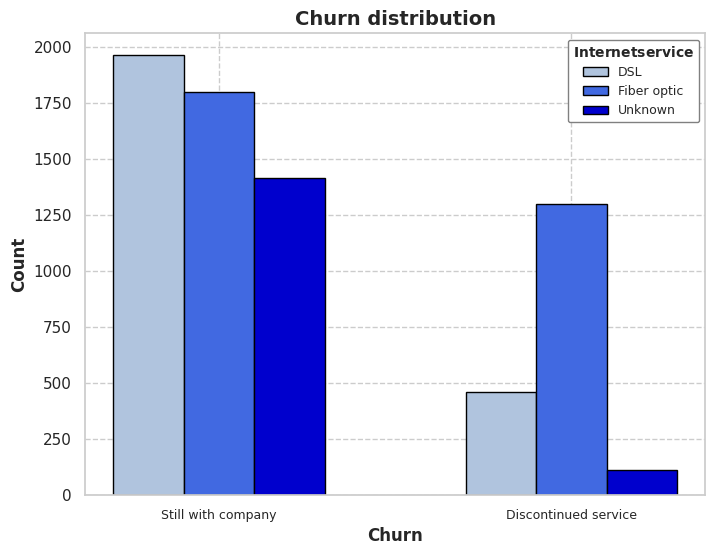

In [24]:
# Create plot figure and subplot
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111)

# Create labels and x axis position
x = np.arange(2)
xlabels = ['Still with company', 'Discontinued service']
xpositions = [0, 1]
width = 0.20

# Plot bar chart
plt.bar(x-0.20, churn_internet_group['count'].iloc[0:2], width, color='lightsteelblue', edgecolor='black')
plt.bar(x, churn_internet_group['count'].iloc[2:4], width, color='royalblue', edgecolor='black')
plt.bar(x+0.20, churn_internet_group['count'].iloc[4:6], width, color='mediumblue', edgecolor='black')

# Add title, axis labels, and legend
plt.title('Churn distribution', fontsize=14, fontweight='bold')
plt.xlabel('Churn', fontweight='bold')
plt.ylabel('Count', fontweight='bold')
plt.xticks(xpositions, xlabels, fontsize=9)
plt.legend(title=r'$\bf{Internet service}$', title_fontsize=10, fontsize=9, labels=['DSL', 'Fiber optic', 'Unknown'], 
           loc='upper right', framealpha=1.0, edgecolor='gray')

# Add grid and set below figure
ax.grid(True, axis='both', linestyle='dashed')
ax.set_axisbelow(True)

# Display chart
plt.show()

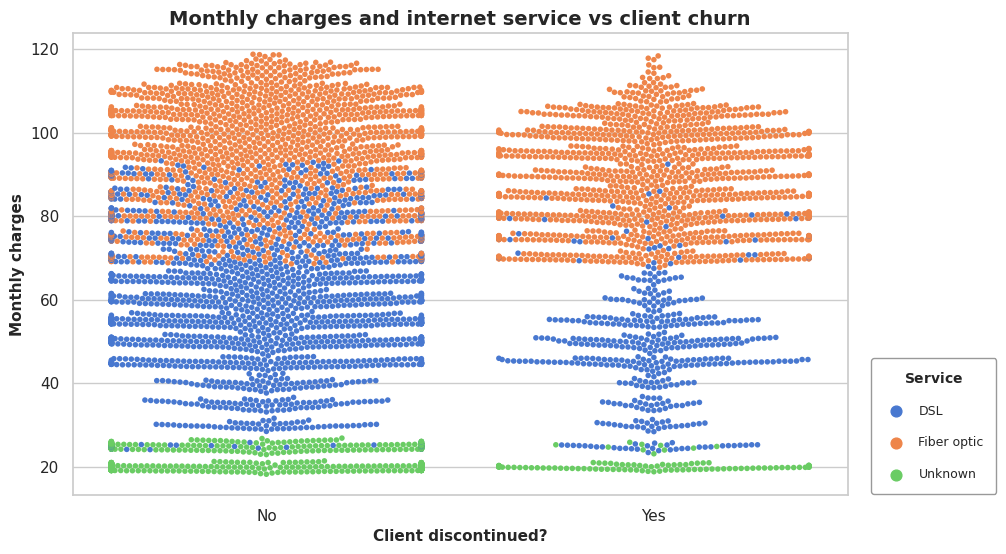

In [25]:
# Plot figure and axis
fig = plt.figure(figsize=(10, 6))

# Create swarmplot
sns.set(style='whitegrid', palette='muted')
sns.swarmplot(data=data_copy, x='discontinued', y='monthlycharges', hue='internetservice', size=4)

# Add title, labels, and legend
plt.title('Monthly charges and internet service vs client churn', fontweight='bold', fontsize=14)
plt.xlabel('Client discontinued?', fontsize=11, fontweight='bold')
plt.ylabel('Monthly charges', fontsize=11, fontweight='bold')
plt.legend(title=r'$\bf{Service}$', title_fontsize=10, fontsize=9, bbox_to_anchor=(1.2, -0.01),
           loc='lower right', labelspacing=1.5, frameon=True, borderpad=1, edgecolor='gray')

# Display plot
plt.show()

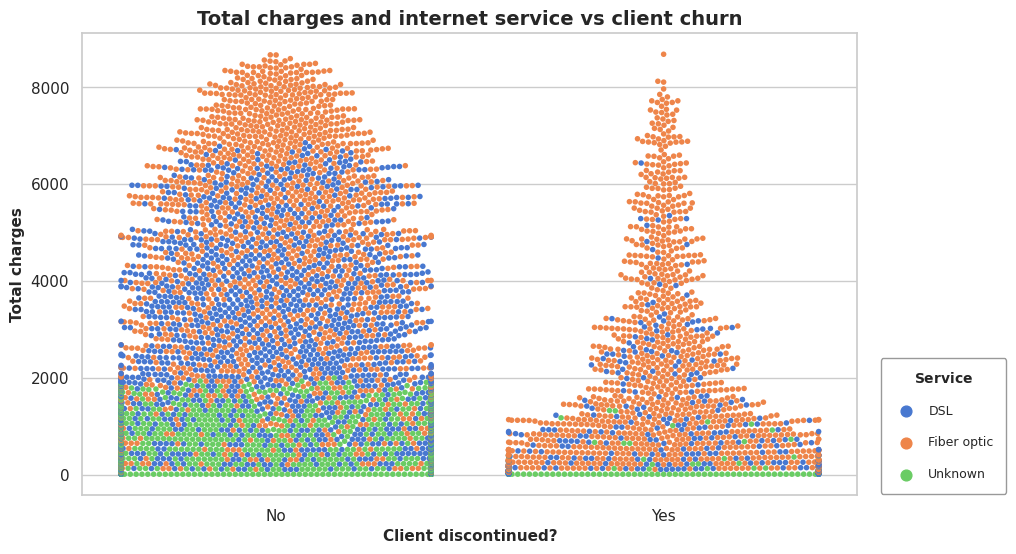

In [26]:
# Plot figure and axis
fig = plt.figure(figsize=(10, 6))

# Create swarmplot
sns.set(style='whitegrid', palette='muted')
sns.swarmplot(data=data_copy, x='discontinued', y='totalcharges', hue='internetservice', size=4)

# Add title, labels, and legend
plt.title('Total charges and internet service vs client churn', fontweight='bold', fontsize=14)
plt.xlabel('Client discontinued?', fontsize=11, fontweight='bold')
plt.ylabel('Total charges', fontsize=11, fontweight='bold')
plt.legend(title=r'$\bf{Service}$', title_fontsize=10, fontsize=9, bbox_to_anchor=(1.2, -0.01),
           loc='lower right', labelspacing=1.5, frameon=True, borderpad=1, edgecolor='gray')

# Display plot
plt.show()

<b>Conclusions</b>

There is a clear contrast between customers that discontinue service and the internet service they have. Almost <b><font color='red'>19%</font></b> of customers with DSL have discontinued service, but nearly <b><font color='red'>42%</font></b> of customers with fiber optic have discontinued service. It seems that customers on fiber optic are unhappy with the service they are being provided. Could the unhappiness stem from the charges being applied? Based on the swarmplots, this could be the case. Out of customers that have discontinued service that were on fiber optic, the monthly charges for these customers were much higher than customers on DSL. This argument is a little less persuasive for total charges, but the same trend in the swarmplot is true here as well.

### Contract length comparison

Does the contract length play a part in a customer's future behavior? Do customers on longer contract lengths tend to stay longer because of the contract? Does the flexibility given in a month-to-month contract cause some customers to eventually leave?

In [27]:
# Get value counts of type field
churn_contract_group = data_copy.groupby(['type', 'discontinued']).count()['customerid'].reset_index().rename(columns={'type': 'contractlength', 'customerid': 'count'})

# Create an empty percentage column
churn_contract_group['percentage'] = ''

# Define total variables for each internet service
MTM_total = churn_contract_group[churn_contract_group['contractlength'] == 'Month-to-month']['count'].sum()
OY_total = churn_contract_group[churn_contract_group['contractlength'] == 'One year']['count'].sum()
TY_total = churn_contract_group[churn_contract_group['contractlength'] == 'Two year']['count'].sum()

# Update percentage column
churn_contract_group['percentage'] = np.where(churn_contract_group['contractlength'] == 'Month-to-month', 
                                              ((churn_contract_group['count'] / MTM_total) * 100).round(2), churn_contract_group['percentage'])
churn_contract_group['percentage'] = np.where(churn_contract_group['contractlength'] == 'One year', 
                                              ((churn_contract_group['count'] / OY_total) * 100).round(2), churn_contract_group['percentage'])
churn_contract_group['percentage'] = np.where(churn_contract_group['contractlength'] == 'Two year', 
                                              ((churn_contract_group['count'] / TY_total) * 100).round(2), churn_contract_group['percentage'])
# Display table
display(churn_contract_group)

contractlength discontinued  count percentage
0  Month-to-month           No   2220      57.29
1  Month-to-month          Yes   1655      42.71
2        One year           No   1307      88.73
3        One year          Yes    166      11.27
4        Two year           No   1647      97.17
5        Two year          Yes     48       2.83

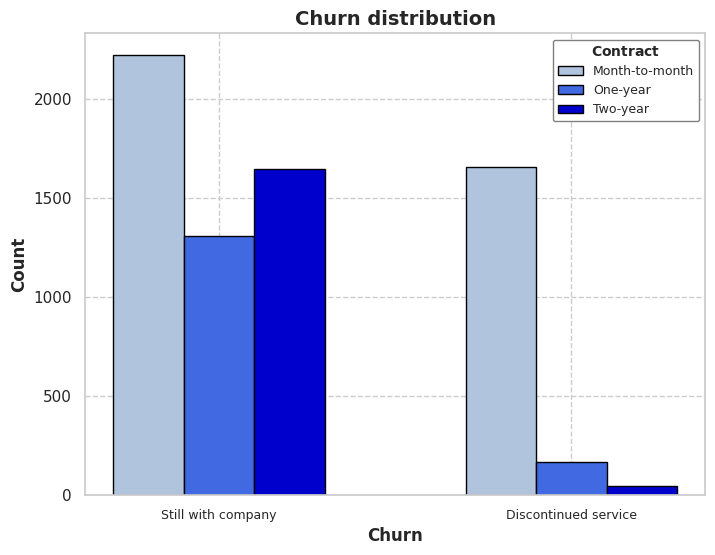

In [28]:
# Create plot figure and subplot
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111)

# Create labels and x axis position
x = np.arange(2)
xlabels = ['Still with company', 'Discontinued service']
xpositions = [0, 1]
width = 0.20

# Plot bar chart
plt.bar(x-0.20, churn_contract_group['count'].iloc[0:2], width, color='lightsteelblue', edgecolor='black')
plt.bar(x, churn_contract_group['count'].iloc[2:4], width, color='royalblue', edgecolor='black')
plt.bar(x+0.20, churn_contract_group['count'].iloc[4:6], width, color='mediumblue', edgecolor='black')

# Add title, axis labels, and legend
plt.title('Churn distribution', fontsize=14, fontweight='bold')
plt.xlabel('Churn', fontweight='bold')
plt.ylabel('Count', fontweight='bold')
plt.xticks(xpositions, xlabels, fontsize=9)
plt.legend(title=r'$\bf{Contract}$', title_fontsize=10, fontsize=9, labels=['Month-to-month', 'One-year', 'Two-year'], 
           loc='upper right', framealpha=1.0, edgecolor='gray')

# Add grid and set below figure
ax.grid(True, axis='both', linestyle='dashed')
ax.set_axisbelow(True)

# Display chart
plt.show()

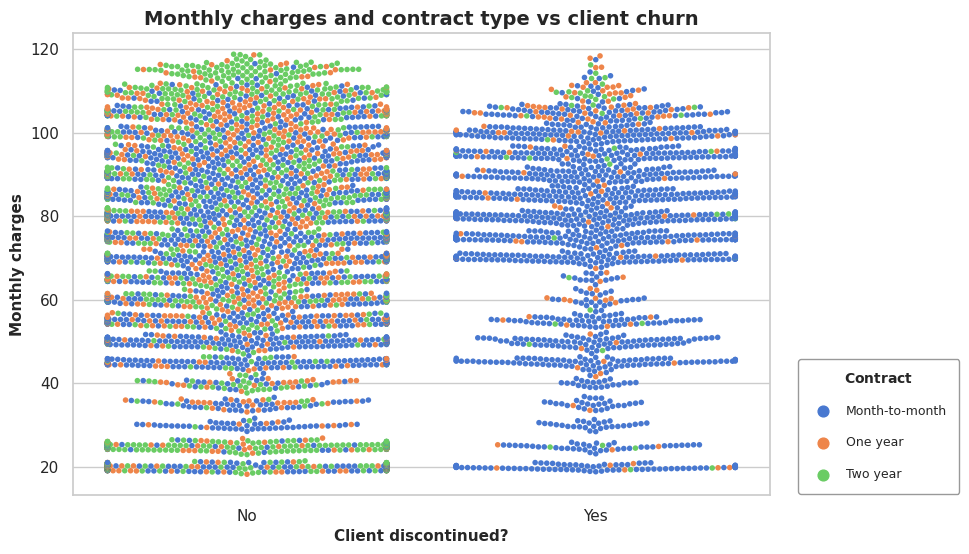

In [29]:
# Plot figure and axis
fig = plt.figure(figsize=(9, 6))

# Create swarmplot
sns.set(style='whitegrid', palette='muted')
sns.swarmplot(data=data_copy, x='discontinued', y='monthlycharges', hue='type', size=4)

# Add title, labels, and legend
plt.title('Monthly charges and contract type vs client churn', fontweight='bold', fontsize=14)
plt.xlabel('Client discontinued?', fontsize=11, fontweight='bold')
plt.ylabel('Monthly charges', fontsize=11, fontweight='bold')
plt.legend(title=r'$\bf{Contract}$', title_fontsize=10, fontsize=9, bbox_to_anchor=(1.28, -0.01),
           loc='lower right', labelspacing=1.5, frameon=True, borderpad=1, edgecolor='gray')

# Display plot
plt.show()

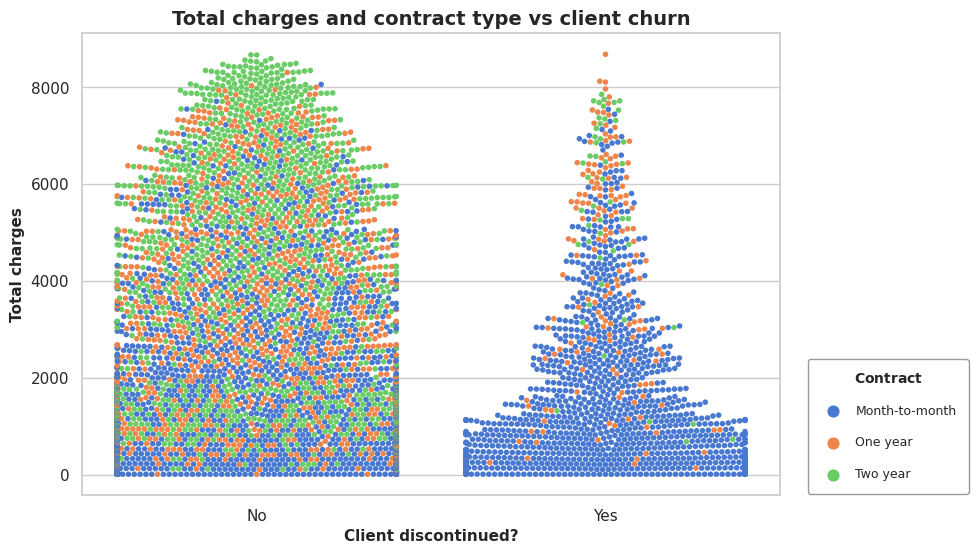

In [30]:
# Plot figure and axis
fig = plt.figure(figsize=(9, 6))

# Create swarmplot
sns.set(style='whitegrid', palette='muted')
sns.swarmplot(data=data_copy, x='discontinued', y='totalcharges', hue='type', size=4)

# Add title, labels, and legend
plt.title('Total charges and contract type vs client churn', fontweight='bold', fontsize=14)
plt.xlabel('Client discontinued?', fontsize=11, fontweight='bold')
plt.ylabel('Total charges', fontsize=11, fontweight='bold')
plt.legend(title=r'$\bf{Contract}$', title_fontsize=10, fontsize=9, bbox_to_anchor=(1.28, -0.01),
           loc='lower right', labelspacing=1.5, frameon=True, borderpad=1, edgecolor='gray')

# Display plot
plt.show()

<b>Conclusions</b>

The initial assumption that customers on month-to-month contracts take advantage of the flexibility was proven correct. Nearly <b><font color='red'>43%</font></b> of customers on month-to-month contracts ended up discontinuing service. The one year and two year contract types had percentages of <b><font color='red'>11%</font></b> and <b><font color='red'>3%</font></b> respectively. Even though this is the case with month-to-month contracts, this should be expected behavior with this contract length. Month-to-months are also sometimes used as a tactic to prevent customers from leaving, because they have extra flexibility to leave when is desired. From a promotional deal and plan option perspective, it should be well known that these customers could leave at any time, so being proactive and aware with these customers is important. The swarmplots of charges provide good information about the dollars customers spend and the contract length they are on, but the information is expected. Longer contracts means more dollars spent because you are in a longer term.

### Monthly and total charges comparison

Let's take a deeper dive into the monthly and total charges that customers have to pay. Do higher charges play a role in the decision of discontinuing service or not, and how quick (tenure) are these decisions made?

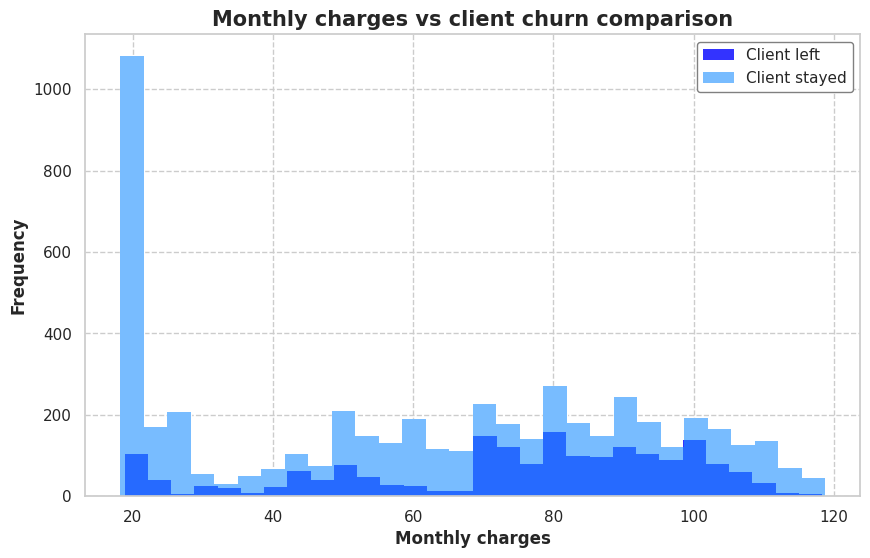

In [31]:
# Create variables for histogram inputs
monthly_yes = data_copy[data_copy['discontinued'] == 'Yes']['monthlycharges']
monthly_no = data_copy[data_copy['discontinued'] == 'No']['monthlycharges']

# Create plot figure and subplot
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111)

# Add histograms for background, primary cleaner, and final for all elements
ax.hist(monthly_yes, color='white', bins=30)
ax.hist(monthly_no, color='white', bins=30)
ax.hist(monthly_yes, label='Client left', bins=30, alpha=0.8, color='blue', edgecolor='none')
ax.hist(monthly_no, label='Client stayed', bins=30, alpha=0.6, color='dodgerblue', edgecolor='none')

# Add grid and set below figure
ax.grid(True, axis='both', linestyle='dashed')
ax.set_axisbelow(True)

# Add legend and labels
plt.legend(facecolor='white', framealpha=1, loc='upper right', edgecolor='gray')
plt.title('Monthly charges vs client churn comparison', fontsize=15, fontweight='bold')
plt.xlabel('Monthly charges', fontweight='bold')
plt.ylabel('Frequency', fontweight='bold')
plt.show()

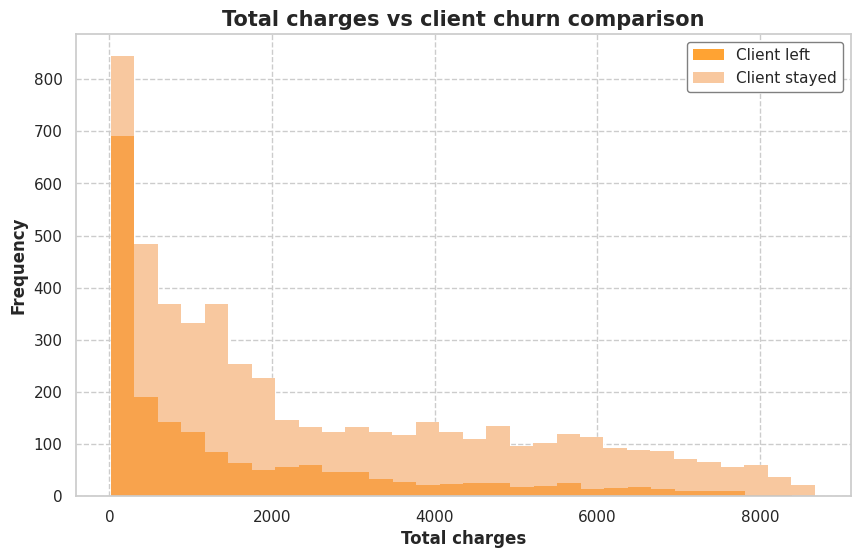

In [32]:
# Create variables for histogram inputs
total_yes = data_copy[data_copy['discontinued'] == 'Yes']['totalcharges']
total_no = data_copy[data_copy['discontinued'] == 'No']['totalcharges']

# Create plot figure and subplot
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111)

# Add histograms for background, primary cleaner, and final for all elements
ax.hist(total_yes, color='white', bins=30)
ax.hist(total_no, color='white', bins=30)
ax.hist(total_yes, label='Client left', bins=30, alpha=0.8, color='darkorange', edgecolor='none')
ax.hist(total_no, label='Client stayed', bins=30, alpha=0.6, color='sandybrown', edgecolor='none')

# Add grid and set below figure
ax.grid(True, axis='both', linestyle='dashed')
ax.set_axisbelow(True)

# Add legend and labels
plt.legend(facecolor='white', framealpha=1, loc='upper right', edgecolor='gray')
plt.title('Total charges vs client churn comparison', fontsize=15, fontweight='bold')
plt.xlabel('Total charges', fontweight='bold')
plt.ylabel('Frequency', fontweight='bold')
plt.show()

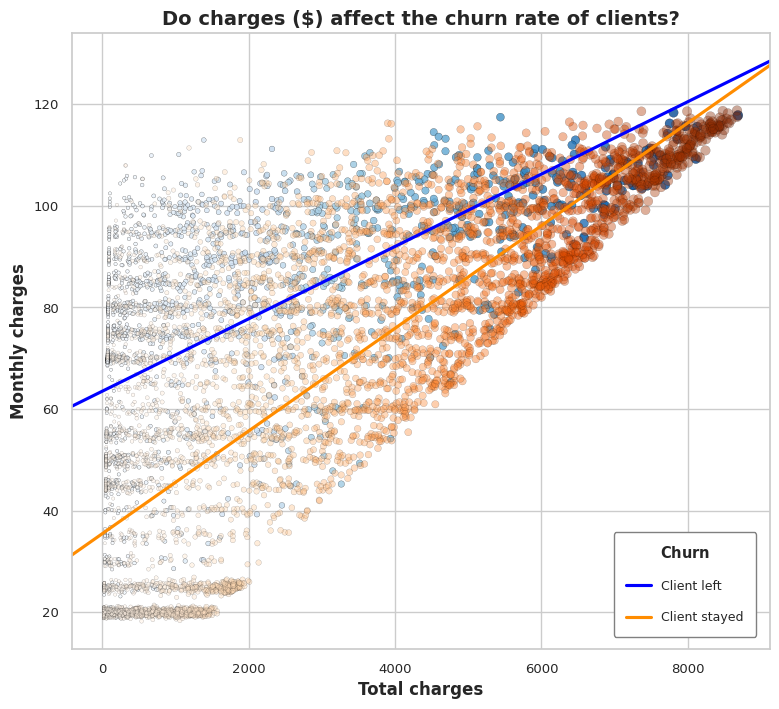

In [33]:
# Create variables for scatterplot inputs
discontinued_yes = data_copy[data_copy['discontinued'] == 'Yes']
discontinued_no = data_copy[data_copy['discontinued'] == 'No']

# Create plot figure
plt.figure(figsize=(9, 8))

# Plot scatter plots and regression lines
sns.scatterplot(data=discontinued_yes, x='totalcharges', y='monthlycharges', hue='totalcharges',
                size='totalcharges', edgecolor='black', palette='Blues', alpha=0.8, sizes=(5, 50))
sns.regplot(x=discontinued_yes['totalcharges'],
            y=discontinued_yes['monthlycharges'], scatter=False, color='blue', ci=None, truncate=False)
sns.scatterplot(data=discontinued_no, x='totalcharges', y='monthlycharges', hue='totalcharges',
                size='totalcharges', edgecolor='black', palette='Oranges', alpha=0.4, sizes=(5, 50))
sns.regplot(x=discontinued_no['totalcharges'],
            y=discontinued_no['monthlycharges'], scatter=False, color='darkorange', ci=None, truncate=False)

# Add title, axis labels, and legend
plt.xlabel('Total charges', fontweight='bold')
plt.xticks(fontsize=9.5)
plt.ylabel('Monthly charges', fontweight='bold')
plt.yticks(fontsize=9.5)
plt.title(label='Do charges ($) affect the churn rate of clients?', fontweight='bold', fontsize=14)
plt.legend(title=r'$\bf{Churn}$', title_fontsize=10.5, loc='lower right', framealpha=1, bbox_to_anchor=(0.99, 0.01), 
           labels=['Client left', 'Client stayed'], labelspacing=1.5, fontsize=9, facecolor='white',
           frameon=True, edgecolor='gray', borderpad=1)

# Display plot
plt.grid(True)
plt.show()

<b>Conclusions</b>

The first two plots compare the charges of customers that have discontinued to service and are still with the company. The trends and patterns between both groups for monthly charges and total charges are very similiar. However, there is one important difference with total charges. The number of customers that have discontinued service is much higher for total charges that are relatively low (first bar or bin). Proportionally, this histogram bar or bin is more than all the other bins combined. This might suggest that total charges do not play a big role in the decision of leaving or not, especially given that the number of customers that have left that had low charges is much more than the number of customers that have not left, proportionally.

## Feature engineering

Before model building and analysis could take place, there were several feature engineering tasks that needed to be performed. The feature engineering tasks included:

- The <b><mark>enddate</mark></b> field held different types of information. If a client was no longer an active customer, the value was the date in which the customer discontinued serivce. However, if a client was still an active customer, the value was <b>No</b>. The problem in which is being solved is a binary classification problem. So, a new Boolean field, called <b><mark>discontinued</mark></b>, was created that has only <b>Yes</b> or <b>No</b> values
    - The new <b><mark>discontinued</mark></b> field is the new target and replaced <b><mark>enddate</mark></b>. So, <b><mark>enddate</mark></b> was removed from the dataset
- To properly encode the <b><mark>begindate</mark></b> field, the year and month were extracted and are represented by the <b><mark>beginyear</mark></b> and <b><mark>beginmonth</mark></b> fields
    - These new fields replaced <b><mark>begindate</mark></b>, so this field was removed from the dataset
- The <b><mark>customerid</mark></b> field does not provide any relevant information in regards to predicting if a client has discontinued service or not. This field has been removed from the dataset
- One-hot encoding was performed on all categorical columns which included the <b><mark>type</mark></b>, <b><mark>paperlessbilling</mark></b>, <b><mark>paymentmethod</mark></b>, <b><mark>internetservice</mark></b>, <b><mark>onlinesecurity</mark></b>, <b><mark>onlinebackup</mark></b>, <b><mark>deviceprotection</mark></b>, <b><mark>techsupport</mark></b>, <b><mark>streamingtv</mark></b>, <b><mark>streamingmovies</mark></b>, <b><mark>gender</mark></b>, <b><mark>partner</mark></b>, <b><mark>dependents</mark></b>, <b><mark>multiplelines</mark></b>, <b><mark>beginyear</mark></b>, <b><mark>beginmonth</mark></b> fields
- Standard scaling was performed on numerical columns which included the <b><mark>monthlycharges</mark></b> and <b><mark>totalcharges</mark></b> fields
    - Both fields underwent a box-cox transformation in an attempt to make the data more normally distributed and less suspectible to outliers. Below are plots and further explanation
    - The <b><mark>seniorcitizen</mark></b> field was already scaled, so it was a part of the scaling procedure

In [34]:
# Create new field representing if client discontinued service
data['discontinued'] = ''
data.loc[data['enddate'] == 'No', 'discontinued'] = 'No'
data.loc[data['enddate'] != 'No', 'discontinued'] = 'Yes'

# Remove enddate field
data = data.drop(['enddate'], axis=1)
display(data[['customerid', 'discontinued']].head())

customerid discontinued
0  7590-VHVEG           No
1  5575-GNVDE           No
2  3668-QPYBK          Yes
3  7795-CFOCW           No
4  9237-HQITU          Yes

In [35]:
# Add new fields for month and year
data['beginyear'] = data['begindate'].dt.year
data['beginmonth'] = data['begindate'].dt.month

# Remove begindate field
data = data.drop(['begindate'], axis=1)
display(data[['customerid', 'beginyear', 'beginmonth']].head())

customerid  beginyear  beginmonth
0  7590-VHVEG       2020           1
1  5575-GNVDE       2017           4
2  3668-QPYBK       2019          10
3  7795-CFOCW       2016           5
4  9237-HQITU       2019           9

In [36]:
# Remove customerid field
data = data.drop(['customerid'], axis=1)

In [37]:
# Identify categorical features to be encoded
categorical_features = ['type', 'paperlessbilling', 'paymentmethod', 'internetservice', 'onlinesecurity', 'onlinebackup', 
                       'deviceprotection', 'techsupport', 'streamingtv', 'streamingmovies', 'gender', 'partner', 'dependents', 
                       'multiplelines', 'beginyear', 'beginmonth']

# Perform one-hot encoding using OneHotEncoder class
encoder = OneHotEncoder(sparse=False)
ohe = encoder.fit_transform(data[categorical_features])
ohe_df = pd.DataFrame(ohe, columns=encoder.get_feature_names(categorical_features))

# Concatenate original DataFrame and encoded DataFrame
data = pd.concat([data, ohe_df], axis=1)

# Drop unnecessary columns
data = data.drop(categorical_features, axis=1)

# Display new DataFrame
display(data.head())

monthlycharges  totalcharges  seniorcitizen discontinued  \
0           29.85         29.85              0           No   
1           56.95       1889.50              0           No   
2           53.85        108.15              0          Yes   
3           42.30       1840.75              0           No   
4           70.70        151.65              0          Yes   

   type_Month-to-month  type_One year  type_Two year  paperlessbilling_No  \
0                  1.0            0.0            0.0                  0.0   
1                  0.0            1.0            0.0                  1.0   
2                  1.0            0.0            0.0                  0.0   
3                  0.0            1.0            0.0                  1.0   
4                  1.0            0.0            0.0                  0.0   

   paperlessbilling_Yes  paymentmethod_Bank transfer (automatic)  ...  \
0                   1.0                                      0.0  ...   
1                   0.0                                      0.0  ...   
2                   1.0                                      0.0  ...   
3                   0.0                                      1.0  ...   
4                   1.0                                      0.0  ...   

   beginmonth_3  beginmonth_4  beginmonth_5  beginmonth_6  beginmonth_7  \
0           0.0           0.0           0.0           0.0           0.0   
1           0.0           1.0           0.0           0.0           0.0   
2           0.0           0.0           0.0           0.0           0.0   
3           0.0           0.0           1.0           0.0           0.0   
4           0.0           0.0           0.0           0.0           0.0   

   beginmonth_8  beginmonth_9  beginmonth_10  beginmonth_11  beginmonth_12  
0           0.0           0.0            0.0            0.0            0.0  
1           0.0           0.0            0.0            0.0            0.0  
2           0.0           0.0            1.0            0.0            0.0  
3           0.0           0.0            0.0            0.0            0.0  
4           0.0           1.0            0.0            0.0            0.0  

[5 rows x 63 columns]

Ideally, the data should be close to a normal distribution before scaling and standardizing the numerical fields in the dataset. Therefore, several plots were created to see how the data was distributed and if transformations needed to be performed before scaling the data.

<b>Monthly charges</b>

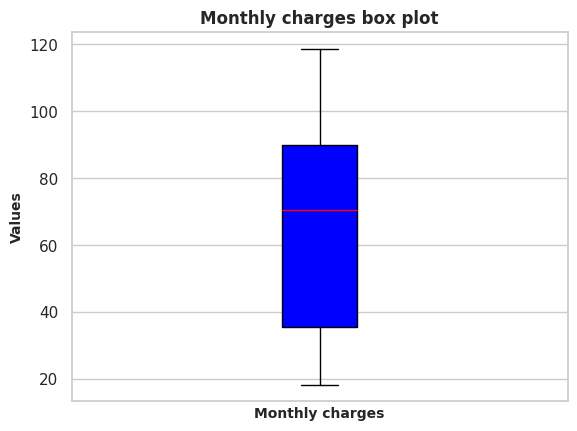

In [38]:
# Create a box plot for monthlycharges
bp = plt.boxplot(data['monthlycharges'], medianprops=dict(color='red'), patch_artist=True, showfliers=True)

# Add title, axis labels, and fill box plot
plt.title('Monthly charges box plot', fontweight='bold')
plt.xlabel('Monthly charges', fontsize=10, fontweight='bold')
plt.ylabel('Values', fontsize=10, fontweight='bold')
plt.gca().set_xticks([])

color = ['blue']
for patch, color in zip(bp['boxes'], color):
    patch.set_facecolor(color)

# Add gridlines
plt.grid(axis='x')

# Display plot
plt.show()

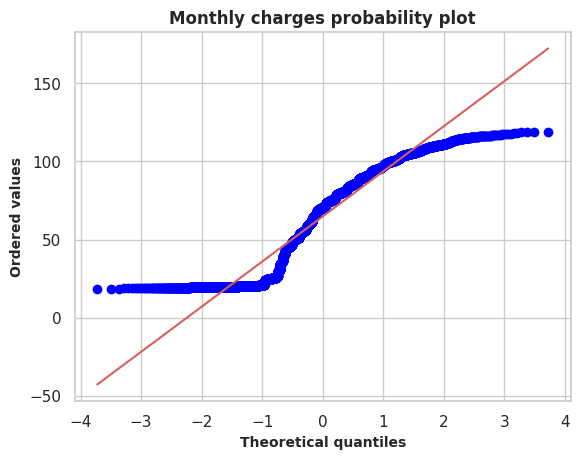

In [39]:
# Create a probability plot to examine monthlycharges distribution
fig, ax = plt.subplots()
stats.probplot(data['monthlycharges'], dist='norm', plot=ax)
ax.get_lines()[0].set_markerfacecolor('blue')
ax.lines[0].set_markeredgecolor('blue')
plt.title('Monthly charges probability plot', fontweight='bold')
plt.xlabel('Theoretical quantiles', fontsize=10, fontweight='bold')
plt.ylabel('Ordered values', fontsize=10, fontweight='bold')
plt.show()

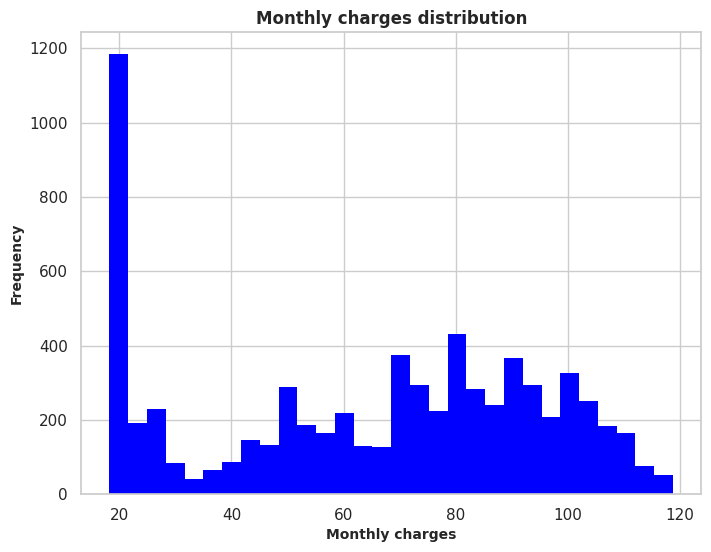

In [40]:
# Plot histogram distribution for monthlycharges
fig = plt.figure(figsize=(8, 6))
plt.hist(data['monthlycharges'], bins=30, edgecolor='None', color='blue')
plt.title('Monthly charges distribution', fontweight='bold')
plt.xlabel('Monthly charges', fontsize=10, fontweight='bold')
plt.ylabel('Frequency', fontsize=10, fontweight='bold')
plt.show()

The three graphs above display the distribution of the data and identify outliers for <b><mark>monthlycharges</mark></b>. Based on the graphs, there are no extreme outliers, the distribution is skewed slightly to the right, and the data is mildly over dispersed. Therefore, it is recommended to perform a <b>box-cox</b> transformation, reducing skewnewss and stablizing variance in the data. 

<b>Total charges</b>

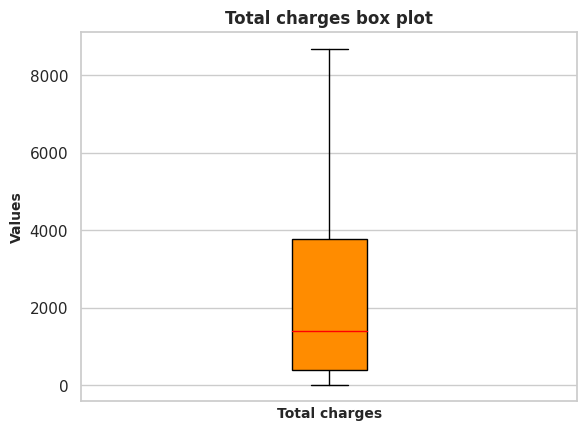

In [41]:
# Create a box plot for totalcharges
bp = plt.boxplot(data['totalcharges'], medianprops=dict(color='red'), patch_artist=True, showfliers=True)

# Add title, axis labels, and fill box plot
plt.title('Total charges box plot', fontweight='bold')
plt.xlabel('Total charges', fontsize=10, fontweight='bold')
plt.ylabel('Values', fontsize=10, fontweight='bold')
plt.gca().set_xticks([])

color = ['darkorange']
for patch, color in zip(bp['boxes'], color):
    patch.set_facecolor(color)

# Add gridlines
plt.grid(axis='x')

# Display plot
plt.show()

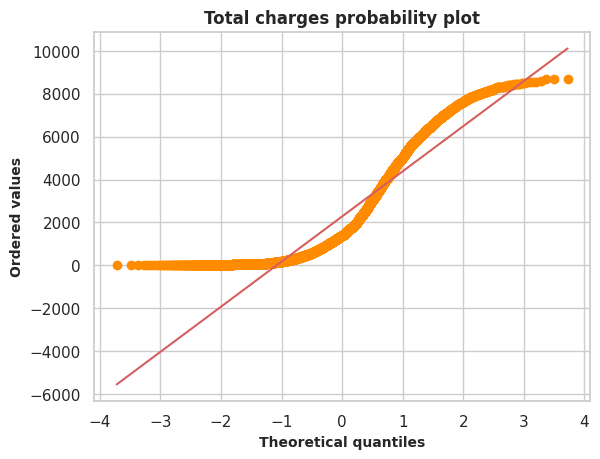

In [42]:
# Create a probability plot to examine totalcharges distribution
fig, ax = plt.subplots()
stats.probplot(data['totalcharges'], dist='norm', plot=ax)
ax.get_lines()[0].set_markerfacecolor('darkorange')
ax.lines[0].set_markeredgecolor('darkorange')
plt.title('Total charges probability plot', fontweight='bold')
plt.xlabel('Theoretical quantiles', fontsize=10, fontweight='bold')
plt.ylabel('Ordered values', fontsize=10, fontweight='bold')
plt.show()

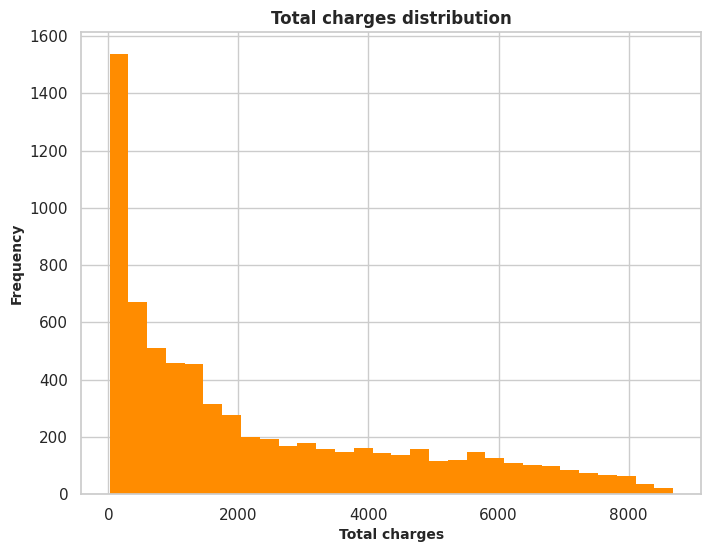

In [43]:
# Plot histogram distribution for totalcharges
fig = plt.figure(figsize=(8, 6))
plt.hist(data['totalcharges'], bins=30, edgecolor='None', color='darkorange')
plt.title('Total charges distribution', fontweight='bold')
plt.xlabel('Total charges', fontsize=10, fontweight='bold')
plt.ylabel('Frequency', fontsize=10, fontweight='bold')
plt.show()

The three graphs above display the distribution of the data and identify outliers for <b><mark>totalcharges</mark></b>. Based on the graphs, there are no extreme outliers, the distribution is skewed heavily to the right, and the data is mildly over dispersed. Therefore, as with <b><mark>monthlycharges</mark></b>, it is recommended to perform a <b>box-cox</b> transformation, reducing skewnewss and stablizing variance in the data. 

In [44]:
# Apply box cox transformation to fields
data['monthlycharges'] = power_transform(data[['monthlycharges']], method='box-cox')
data['totalcharges'] = power_transform(data[['totalcharges']], method='box-cox')

# Scale the transformed data using StandardScaler
numerical_features = ['monthlycharges', 'totalcharges']
scaler = StandardScaler()
data['monthlycharges'] = scaler.fit_transform(data[numerical_features])
data['totalcharges'] = scaler.fit_transform(data[numerical_features])
display(data.head())

monthlycharges  totalcharges  seniorcitizen discontinued  \
0       -1.158157     -1.158157              0           No   
1       -0.236899     -0.236899              0           No   
2       -0.340068     -0.340068              0          Yes   
3       -0.728976     -0.728976              0           No   
4        0.215555      0.215555              0          Yes   

   type_Month-to-month  type_One year  type_Two year  paperlessbilling_No  \
0                  1.0            0.0            0.0                  0.0   
1                  0.0            1.0            0.0                  1.0   
2                  1.0            0.0            0.0                  0.0   
3                  0.0            1.0            0.0                  1.0   
4                  1.0            0.0            0.0                  0.0   

   paperlessbilling_Yes  paymentmethod_Bank transfer (automatic)  ...  \
0                   1.0                                      0.0  ...   
1                   0.0                                      0.0  ...   
2                   1.0                                      0.0  ...   
3                   0.0                                      1.0  ...   
4                   1.0                                      0.0  ...   

   beginmonth_3  beginmonth_4  beginmonth_5  beginmonth_6  beginmonth_7  \
0           0.0           0.0           0.0           0.0           0.0   
1           0.0           1.0           0.0           0.0           0.0   
2           0.0           0.0           0.0           0.0           0.0   
3           0.0           0.0           1.0           0.0           0.0   
4           0.0           0.0           0.0           0.0           0.0   

   beginmonth_8  beginmonth_9  beginmonth_10  beginmonth_11  beginmonth_12  
0           0.0           0.0            0.0            0.0            0.0  
1           0.0           0.0            0.0            0.0            0.0  
2           0.0           0.0            1.0            0.0            0.0  
3           0.0           0.0            0.0            0.0            0.0  
4           0.0           1.0            0.0            0.0            0.0  

[5 rows x 63 columns]

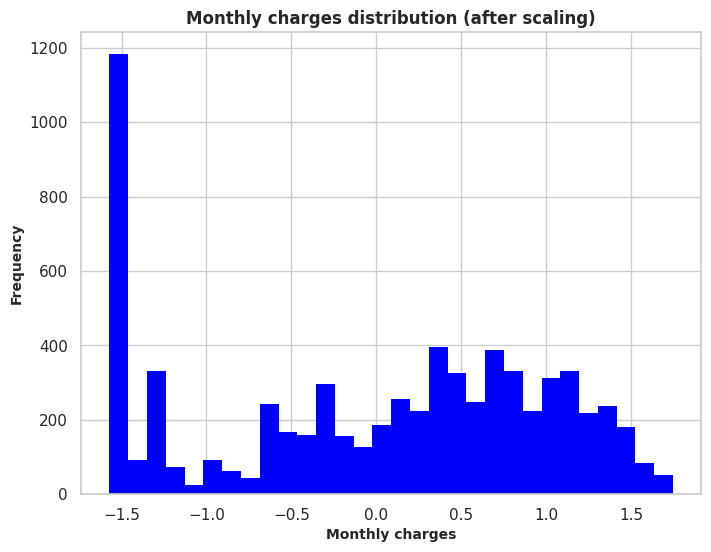

In [45]:
# Plot histogram distribution for monthlycharges after transformation and scaling
fig = plt.figure(figsize=(8, 6))
plt.hist(data['monthlycharges'], bins=30, edgecolor='None', color='blue')
plt.title('Monthly charges distribution (after scaling)', fontweight='bold')
plt.xlabel('Monthly charges', fontsize=10, fontweight='bold')
plt.ylabel('Frequency', fontsize=10, fontweight='bold')
plt.show()

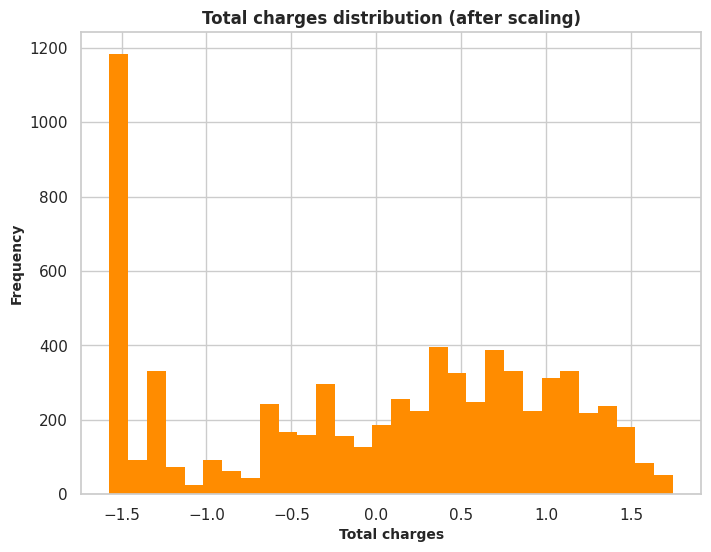

In [46]:
# Plot histogram distribution for totalcharges after transformation and scaling
fig = plt.figure(figsize=(8, 6))
plt.hist(data['totalcharges'], bins=30, edgecolor='None', color='darkorange')
plt.title('Total charges distribution (after scaling)', fontweight='bold')
plt.xlabel('Total charges', fontsize=10, fontweight='bold')
plt.ylabel('Frequency', fontsize=10, fontweight='bold')
plt.show()

## Model preparation

Before models could be created, fine-tuned, and evaluated, the following model preparation tasks were performed to get the datasets ready.

- Features and the target were defined
    - The target is the <b><mark>discontinued</mark></b> field
- The dataset was split into training, validation, and test datasets
    - The dataset was split using a 3:1:1 ratio. That is, 60% of the data represents the training dataset, and 20% represents the validation dataset, and 20% represents the test dataset
    - These sizes and splits ensure that most of the data is for properly training the model, but there is still enough data to fine-tune and evaluate
- Upsampling was performed for the training dataset to fix the class imbalanace in the data. Approximately <font color='red'><b>73%</font></b> of the values are class <b>No</b>. After increasing the number of samples, only <font color='red'><b>57%</font></b> of values are now class <b>No</b>
    - Positive observations were multiplied by a <font color='red'><b>factor of 2</font></b>. Mulitplying by a higher integer resulted in more class <b>Yes</b> observations, which was not preferred. For that reason, it was elected to keep <b>No</b> as the majority class and multiply by a factor of 2
- Three functions were created to streamline model building and analysis
    - <b>build_model</b> - Gathers model predictions, retrieves AUC-ROC and accuarcy scores, and plots a ROC curve
    - <b>build_confusion_matrix</b> - Creates a confusion matrix describing how the model made predictions
    - <b>build_table</b> - Creates a summary table of the AUC-ROC scores of 3 models: logistic regression, the unoptimized model, and optimized / fine-tuned model
- A logistic regression base model was created to serve as a baseline for comparison to other models. Here were the final metrics:
    - AUC-ROC: <b><font color='red'>0.8648</font></b>
    - Accuarcy: <b><font color='red'>0.7835</font></b>

In [47]:
# Define features and target
features = data.drop(['discontinued'], axis=1)
target = data['discontinued']

In [48]:
# Split data into training, validation, and test datasets
features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.2, random_state=100)
features_train, features_valid, target_train, target_valid = train_test_split(features_train, target_train, test_size=0.25, random_state=100)

class  count  percentage
0    No   3082       72.95
1   Yes   1143       27.05

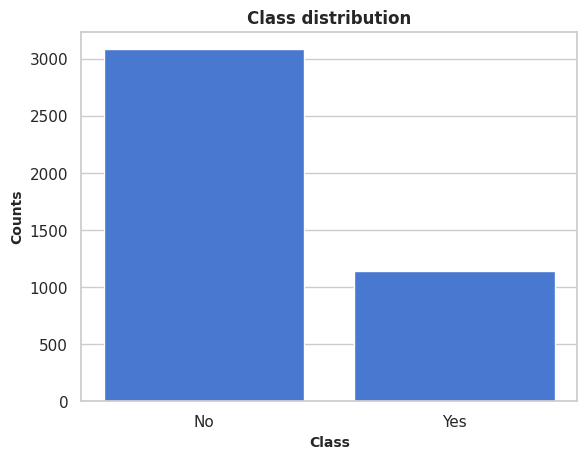

In [49]:
# Get value counts of target
target_counts = target_train.value_counts().reset_index().rename(columns={'index': 'class', 'discontinued': 'count'})

# Create a percentage column
target_counts['percentage'] = ((target_counts['count'] / target_counts['count'].sum()) * 100).round(2)
display(target_counts)

# Plot class counts
plt.bar(target_counts['class'], target_counts['count'])
plt.title('Class distribution', fontweight='bold')
plt.xlabel('Class', fontsize=10, fontweight='bold')
plt.ylabel('Counts', fontsize=10, fontweight='bold')
plt.grid(axis='x')
plt.show()

In [50]:
# !pip install -U imbalanced-learn

# from imblearn.over_sampling import ADASYN
# adasyn = ADASYN(sampling_strategy='minority')
# features_train_resampled, target_train_resampled = adasyn.fit_resample(features_train, target_train)
# target_counts = target_train_resampled.value_counts().reset_index().rename(columns={'index': 'class', 'discontinued': 'count'})
# display(target_counts)

In [51]:
# Split training dataset into class No and Yes
features_train_no = features_train[target_train == 'No']
features_train_yes = features_train[target_train == 'Yes']
target_train_no = target_train[target_train == 'No']
target_train_yes = target_train[target_train == 'Yes']

# Duplicate the class Yes observations by a factor of 2
features_train_upsampled = pd.concat([features_train_no] + [features_train_yes] * 2)
target_train_upsampled = pd.concat([target_train_no] + [target_train_yes] * 2)

# Shuffle the data
features_train_upsampled, target_train_upsampled = shuffle(features_train_upsampled, target_train_upsampled, random_state=100)

class  count  percentage
0    No   3082       57.41
1   Yes   2286       42.59

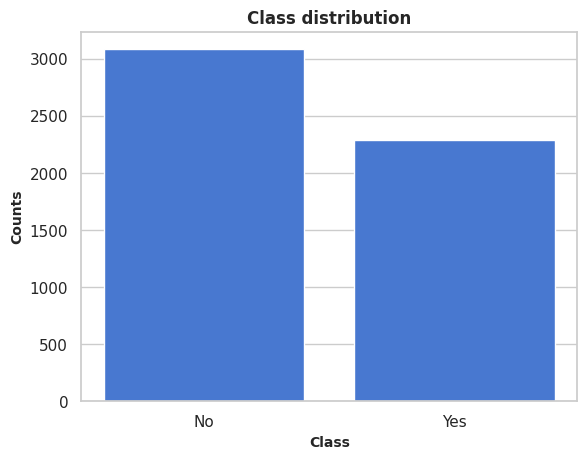

In [52]:
# Get value counts of target
target_counts = target_train_upsampled.value_counts().reset_index().rename(columns={'index': 'class', 'discontinued': 'count'})

# Create a percentage column
target_counts['percentage'] = ((target_counts['count'] / target_counts['count'].sum()) * 100).round(2)
display(target_counts)

# Plot class counts
plt.bar(target_counts['class'], target_counts['count'])
plt.title('Class distribution', fontweight='bold')
plt.xlabel('Class', fontsize=10, fontweight='bold')
plt.ylabel('Counts', fontsize=10, fontweight='bold')
plt.grid(axis='x')
plt.show()

<b>Build model analysis functions</b>

In [53]:
def build_model(model, features_valid, target_valid, graph_label):

    '''This function gathers the predictions of an input model and creates a ROC curve plot.'''
    
    # Gather predictions
    predictions_prob = model.predict_proba(features_valid)[:, 1]
    predictions = model.predict(features_valid)

    # Get the false positive rate (FPR) and true positive rate (TPR) for different classification thresholds
    fpr, tpr, thresholds = roc_curve(target_valid, predictions_prob, pos_label='Yes')

    # Calculate the ROC AUC and accuracy scores
    auc_roc = roc_auc_score(target_valid, predictions_prob).round(4)
    accuracy = accuracy_score(target_valid, predictions).round(4)
    print()
    print('AUC-ROC score:', auc_roc)
    print('Accuracy score:', accuracy)

    # Plot the ROC curve and 'random guess' line
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label='ROC curve')
    plt.plot([0, 1], [0, 1], linestyle='--', color='black', label='Random guess')
    plt.fill_between(fpr, tpr, 0, color='gray', alpha=0.2, label='AUC = %0.2f' % auc_roc)

    # Add title, axis labels, and legend
    plt.title(f"{graph_label} - ROC curve", fontweight='bold')
    plt.xlabel('False positive rate', fontsize=10, fontweight='bold')
    plt.ylabel('True positive rate', fontsize=10, fontweight='bold')
    plt.legend(loc='lower right', framealpha=1, edgecolor='gray')

    # Display plot
    plt.show()

    return predictions, auc_roc, accuracy

In [54]:
def build_confusion_matrix(model, target_valid, predictions):

    '''This function creates a confusion matrix of an input model.'''
    
    # Create and reshape confusion matrix data
    matrix = confusion_matrix(target_valid, predictions)
    matrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]

    # Plot the matrix
    plt.figure(figsize=(8, 4))
    sns.heatmap(matrix, annot=True, annot_kws={'size':11}, cmap=plt.cm.Greens, linewidths=0.2)

    # Add title, axis labels, and tick marks
    plt.title('Confusion matrix', fontsize=14, fontweight='bold')
    plt.xlabel('Predicted label', fontsize=12, fontweight='bold')
    plt.ylabel('True label', fontsize=12, fontweight='bold')

    class_names = ['Client stayed', 'Client discontinued']
    tick_marks = np.arange(len(class_names))
    tick_marks2 = tick_marks + 0.5
    plt.xticks(tick_marks2, class_names, fontsize=9, rotation=0)
    plt.yticks(tick_marks2, class_names, fontsize=9, rotation=0)

    # Display the confusion matrix
    plt.show()

In [55]:
def build_table(auc_lr, acc_lr, auc_base, acc_base, auc_opt, acc_opt):

    '''This function returns a summary table of metrics for three models - the logistic regression base model,
    the unoptimized model, and the optimized model.'''

    # Compare all models
    AUC_list = [auc_lr, auc_base, auc_opt]
    accuracy_list = [acc_lr, acc_base, acc_opt]
    dict = {
        'AUC-ROC': AUC_list,
        'Accuracy': accuracy_list,
    }
    table = pd.DataFrame(dict, index=['Logistic regression', 'Unoptimized model', 'Optimized model'])
    display(table)

<b>Logistic regression base model</b>


AUC-ROC score: 0.8648
Accuracy score: 0.7835


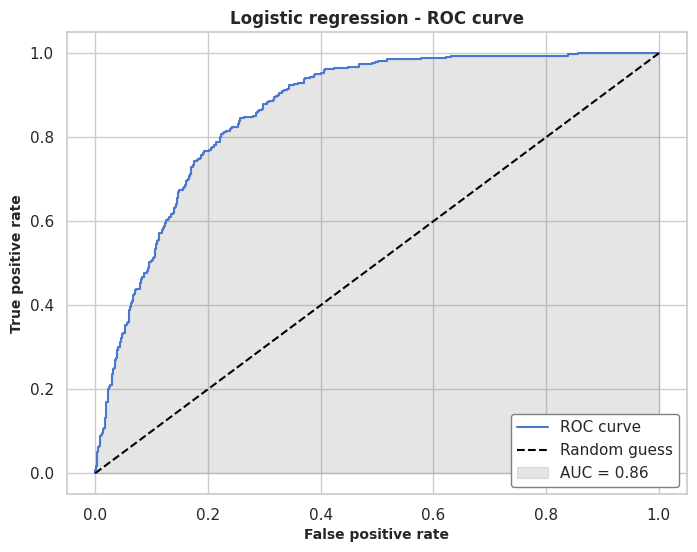

In [56]:
# Create and train a logistic regression model
base_model = LogisticRegression(random_state=100)
base_model.fit(features_train_upsampled, target_train_upsampled)

# Run build_model function to build model, gather predictions, and plot ROC curve
predictions, auc_roc_lr, acc_lr = build_model(base_model, features_valid, target_valid, 'Logistic regression')

The ROC curve for the logistic regression model slightly hugs the top-left corner of the model indicating that the model adequately measures both positive and negative observations with high accuracy. The ROC-AUC score is <b><font color='red'>0.86</font></b>. Moreover, even without hyperparameter tuning or testing other model types, the performance is still acceptable with a basic logistic regression model.

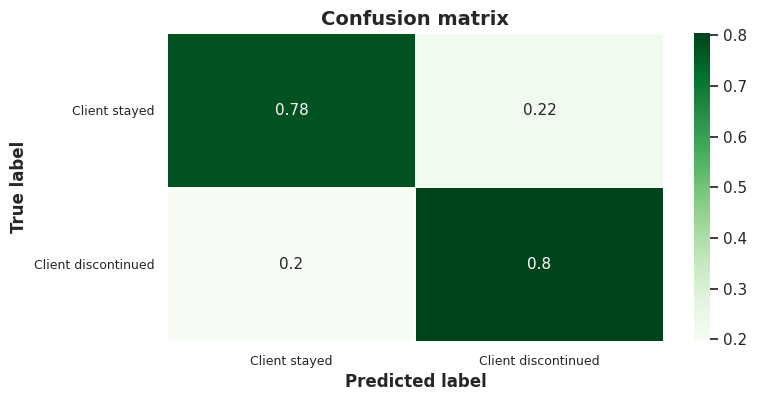

In [57]:
# Run build_confusion_matrix function
build_confusion_matrix(base_model, target_valid, predictions)

The confustion matrix provides additional detail around the TPR, FPR, TNR, and FNR rates. True positives and true negatives scored fairly high, each yielding an accuracy of <font color='red'><b>0.78</font></b> and <font color='red'><b>0.8</font></b> respectively. This means that the model does a pretty good job in predicting positive outcomes when they are actually positive, and negative outcomes when they are actually negative.

## Model building and analysis

There were three models built and fine-tuned to help predict client churn: random forest, K-nearest neighbors, and gradient boosting (Light GBM). An unoptimized model with no modifications or improvements was first built for each model type to establish a performance baseline. Then, hyperparameters were fine-tuned and modifications were made to optimize the model. Lastly, scores and confusion matrices of the logistic regression base model, unoptimized model, and optimized model for each model type were compared for final evaluation of the model's overall performance.

### Random forest classification

Unoptimized model


AUC-ROC score: 0.8534
Accuracy score: 0.8027


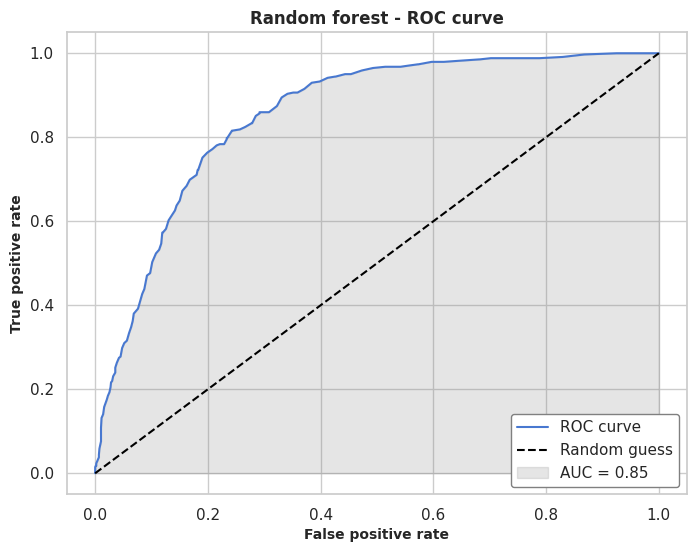

In [58]:
# Create and train model
model_rf = RandomForestClassifier(random_state=100)
model_rf.fit(features_train_upsampled, target_train_upsampled)

# Run build_model function to build model, gather predictions, and plot ROC curve
predictions, auc_roc_rf_base, acc_rf_base = build_model(model_rf, features_valid, target_valid, 'Random forest')

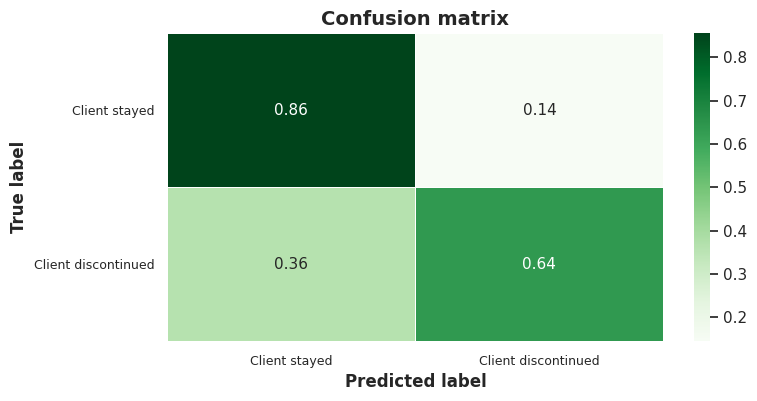

In [59]:
# Run build_confusion_matrix function to create confusion matrix
build_confusion_matrix(model_rf, target_valid, predictions)

Optimized model

In [60]:
# Create parameter grid
param_grid = {'n_estimators': [1] + list(range(20, 100, 10)),
                 'max_depth': [1] + list(range(10, 50, 10)),
                 'min_samples_leaf': [1] + list(range(20, 101, 20)),
                 'min_samples_split': [2] + list(range(20, 101, 20))
                }

# Create model and gridsearch object
model_rf = RandomForestClassifier(random_state=100)
grid_search_rf = GridSearchCV(estimator=model_rf, param_grid=param_grid, cv=5, scoring=['roc_auc', 'accuracy'], refit='roc_auc')

# Train model 
grid_search_rf.fit(features_train_upsampled, target_train_upsampled)

# Get best hyperparameters and scores
print('Best hyperparameters:', grid_search_rf.best_params_)
print('Best score:', grid_search_rf.best_score_)

Best hyperparameters: {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 80}
Best score: 0.9447636073374941


<b>NOTE</b>: The gridsearch object includes both <mark>roc_auc</mark> and <mark>accuarcy</mark> values to evaluate the model's performance .


AUC-ROC score: 0.8498
Accuracy score: 0.7921


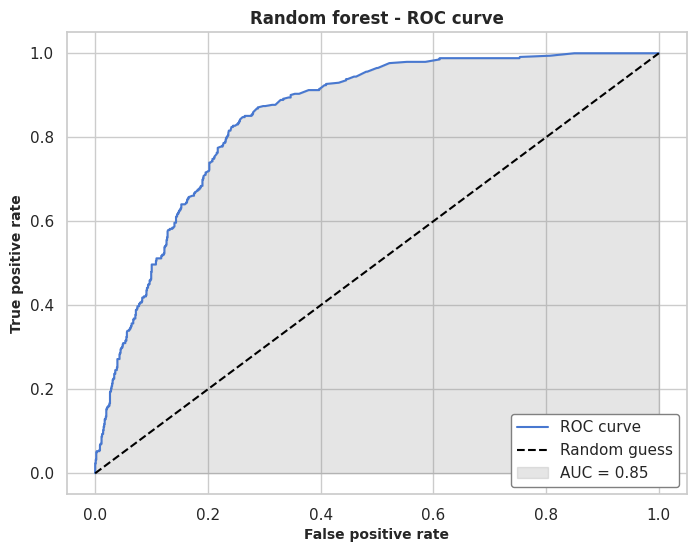

In [61]:
# Create and train model
model_rf = grid_search_rf.best_estimator_
model_rf.fit(features_train_upsampled, target_train_upsampled)

# Run build_model function to build model, gather predictions, and plot ROC curve
predictions, auc_roc_rf_opt, acc_rf_opt = build_model(model_rf, features_valid, target_valid, 'Random forest')

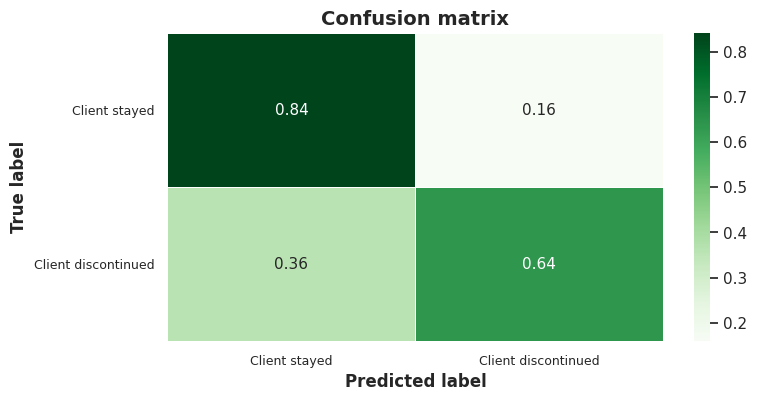

In [62]:
# Run build_confusion_matrix function to create confusion matrix
build_confusion_matrix(model_rf, target_valid, predictions)

<b>Conclusions</b>

The table below displays the overall performance of each model. The unoptimized model which included all parameter defaults performed better even after many iterations of optimization on several parameters. In addition, the logistic regression base model performed better than the unoptimized and optimized models, concluding that a random forest classification might not be the best model for this problem. Morever, as the confusion matrix indicates, the model does an admirable job at predicting the positive class correctly, but does a below average job in predicting the negative class, yielding only a true negative rate of <font color='red'><b>0.64</font></b>.

Several parameters were fine-tuned for their optimal values, but the four below were the final selections based on their impact on the final model outcome. The best values that resulted from the gridsearch object are also included.

- <mark>n_estimators</mark>: 80
- <mark>max_depth</mark>: 20
- <mark>min_samples_leaf</mark>: 1
- <mark>min_samples_split</mark>: 2

In [63]:
# Run build_table function to compare all models
build_table(auc_roc_lr, acc_lr, auc_roc_rf_base, acc_rf_base, auc_roc_rf_opt, acc_rf_opt)

AUC-ROC  Accuracy
Logistic regression   0.8648    0.7835
Unoptimized model     0.8534    0.8027
Optimized model       0.8498    0.7921

### K-nearest neighbor

Unoptimized model


AUC-ROC score: 0.7946
Accuracy score: 0.7431


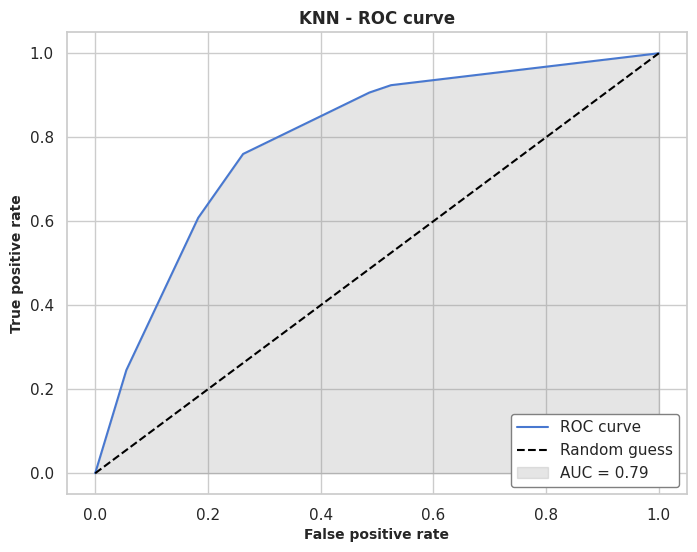

In [64]:
# Create and train model
model_knn = KNeighborsClassifier()
model_knn.fit(features_train_upsampled, target_train_upsampled)

# Run build_model function to build model, gather predictions, and plot ROC curve
predictions, auc_roc_knn_base, acc_knn_base = build_model(model_knn, features_valid, target_valid, 'KNN')

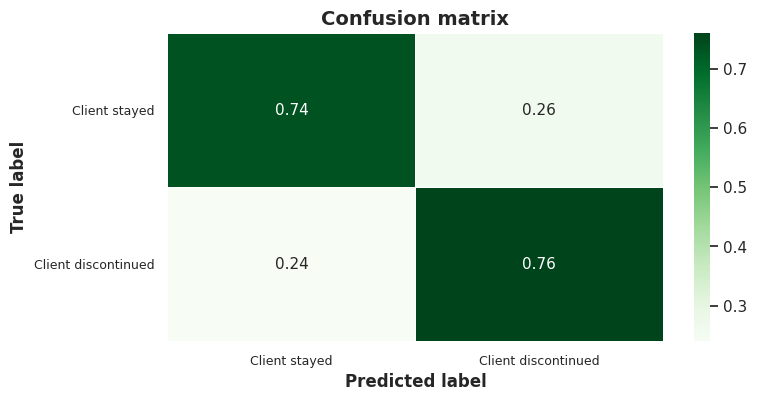

In [65]:
# Run build_confusion_matrix function to create confusion matrix
build_confusion_matrix(model_knn, target_valid, predictions)

Optimized model

In [66]:
# Create parameter grid
param_grid = {
    'n_neighbors': list(range(1, 10)),
    'leaf_size': [1] + list(range(10, 40, 10)),
    'p': [1, 2],
    'weights': ['uniform', 'distance'],
}

# Create model and gridsearch object
model_knn = KNeighborsClassifier()
grid_search_knn = GridSearchCV(estimator=model_knn, param_grid=param_grid, cv=5, scoring=['roc_auc', 'accuracy'], refit='roc_auc')

# Train model
grid_search_knn.fit(features_train_upsampled, target_train_upsampled)

# Get best hyperparameters and scores
print('Best hyperparameters:', grid_search_knn.best_params_)
print('Best score:', grid_search_knn.best_score_)

Best hyperparameters: {'leaf_size': 1, 'n_neighbors': 9, 'p': 1, 'weights': 'distance'}
Best score: 0.9515843174634913



AUC-ROC score: 0.8169
Accuracy score: 0.7459


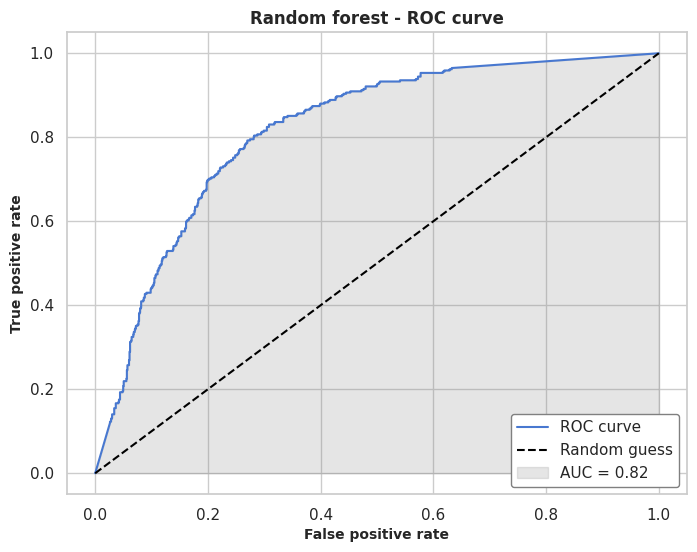

In [67]:
# Create and train model
model_knn = grid_search_knn.best_estimator_
model_knn.fit(features_train_upsampled, target_train_upsampled)

# Run build_model function to build model, gather predictions, and plot ROC curve
predictions, auc_roc_knn_opt, acc_knn_opt =  build_model(model_knn, features_valid, target_valid, 'Random forest')

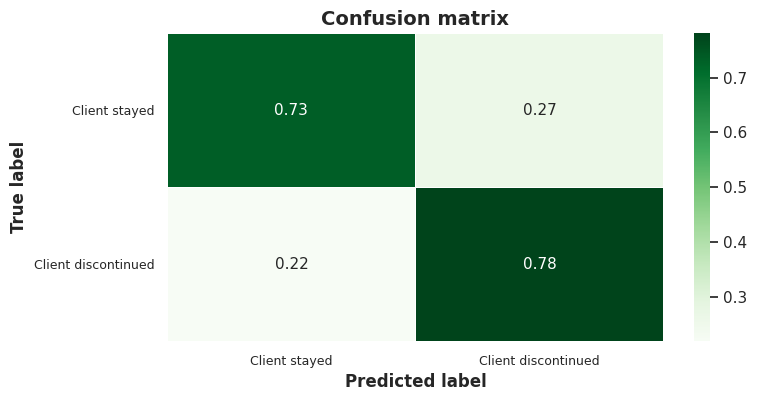

In [68]:
# Run build_confusion_matrix function to create confusion matrix
build_confusion_matrix(model_knn, target_valid, predictions)

<b>Conclusions</b>

Similar to the random forest model, the logistic regression base model performed better than the unoptimized and optimized models. Hyperparameter tuning and modifications to the model did result in better scores, but its performance is still not close to the logistic regression model, and it also did not outperform the random forest model. Even though the model does a better job in predicting the negative class, successfully predicting the positive class was worse, resulting in a worse AUC-ROC and accuarcy scores.

Several parameters were fine-tuned for their optimal values, but the four below were the final selections. The best values that resulted from the gridsearch object are also included.

- <mark>n_neighbors</mark>: 9
- <mark>leaf_size</mark>: 1
- <mark>p</mark>: 1
- <mark>weight</mark>: distance

In [69]:
# Run build_table function to compare all models
build_table(auc_roc_lr, acc_lr, auc_roc_knn_base, acc_knn_base, auc_roc_knn_opt, acc_knn_opt)

AUC-ROC  Accuracy
Logistic regression   0.8648    0.7835
Unoptimized model     0.7946    0.7431
Optimized model       0.8169    0.7459

### Gradient boosting (Light GBM)

Unoptimized model


AUC-ROC score: 0.8471
Accuracy score: 0.7885


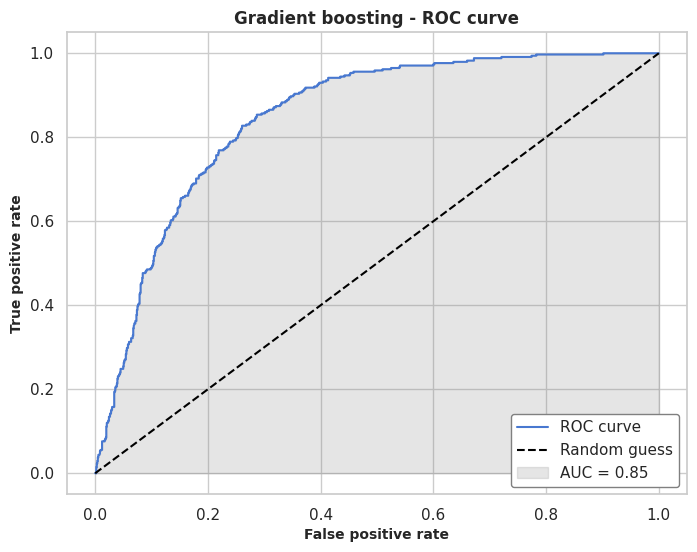

In [70]:
# Create fixed parameter grid
fixed_params = {
    'objective': 'binary',
    'verbose': -1,
    'metric': 'auc',
    'n_jobs': -1,
    'random_state': 100
}

# Create and train model
model_lgm = lgb.LGBMClassifier(**fixed_params)
callbacks = [lgb.log_evaluation(period=0)]
model_lgm.fit(features_train_upsampled, target_train_upsampled, eval_set=(features_valid, target_valid), callbacks=callbacks)

# Run build_model function to build model, gather predictions, and plot ROC curve
predictions, auc_roc_lgm_base, acc_lgm_base = build_model(model_lgm, features_valid, target_valid, 'Gradient boosting')

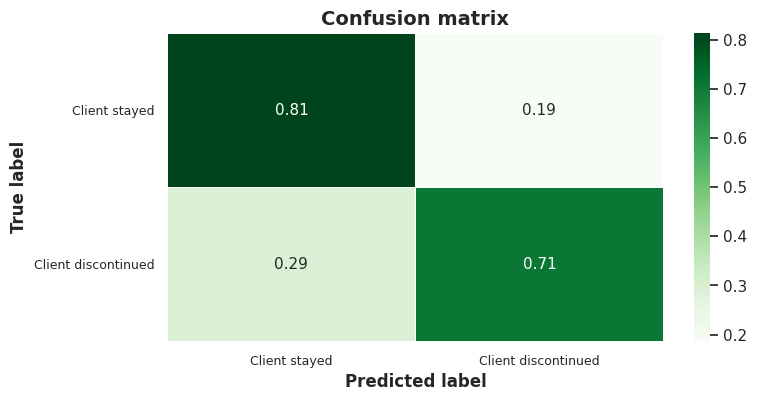

In [71]:
# Run build_confusion_matrix function to create confusion matrix
build_confusion_matrix(model_lgm, target_valid, predictions)

Optimized model

In [72]:
# Create gridsearch parameter grid
param_grid = {
    'num_leaves': [31, 63, 127],
    'max_depth': [-1, 3, 5],
    'n_estimators': [1] + list(range(10, 50, 10)) + [100, 200]
}

# Create model and gridsearch object
model_lgm = lgb.LGBMClassifier(**fixed_params)
grid_search_lgm = GridSearchCV(estimator=model_lgm, param_grid=param_grid, cv=5, scoring=['roc_auc', 'accuracy'], refit='roc_auc')

# Train model
grid_search_lgm.fit(features_train_upsampled, target_train_upsampled, eval_set=(features_valid, target_valid), callbacks=callbacks)

# Get best hyperparameters and scores
print('Best hyperparameters:', grid_search_lgm.best_params_)
print('Best score:', grid_search_lgm.best_score_)

Best hyperparameters: {'max_depth': -1, 'n_estimators': 200, 'num_leaves': 127}
Best score: 0.9343853486496416


<b>NOTE</b>: Even though the gridsearch object yielded a <mark>max_depth</mark> of <b>-1</b> as the best value (see best parameters in the code cell above), updating the parameter to <b>5</b> resulted in a better AUC-ROC score. Since this was the case, a <mark>max_depth</mark> of 5 was used as the final parameter value. In addition, <mark>learning rate</mark> was not included in the gridsearch because of how long it caused the code to run. Therefore, after retrieving the optimal values for the above paramters through the gridsearch, <mark>learning rate</mark> was added to the model and tested as an individual parameter to get its optimal value. The code cell below displays these additions.


AUC-ROC score: 0.8641
Accuracy score: 0.797


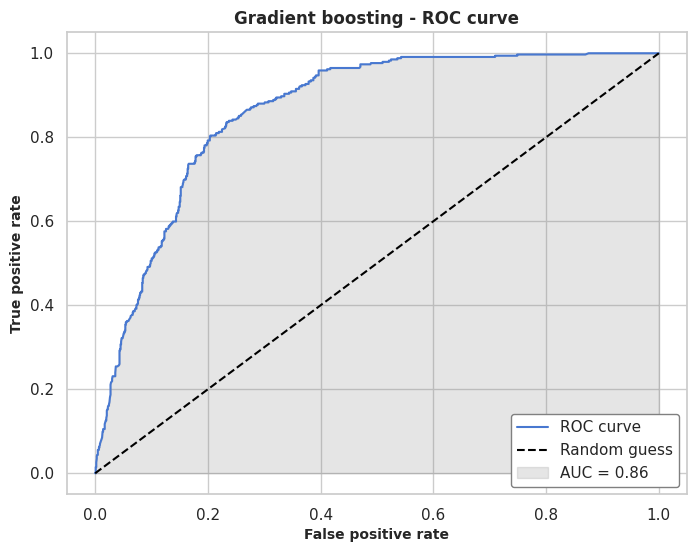

In [84]:
# Create and train model
model_lgm = lgb.LGBMClassifier(**fixed_params, learning_rate=0.01, max_depth=5, n_estimators=200, num_leaves=127)
model_lgm.fit(features_train_upsampled, target_train_upsampled, eval_set=(features_valid, target_valid), callbacks=callbacks)

# Run build_model function to build model, gather predictions, and plot ROC curve
predictions, auc_roc_lgm_opt, acc_lgm_opt = build_model(model_lgm, features_valid, target_valid, 'Gradient boosting')

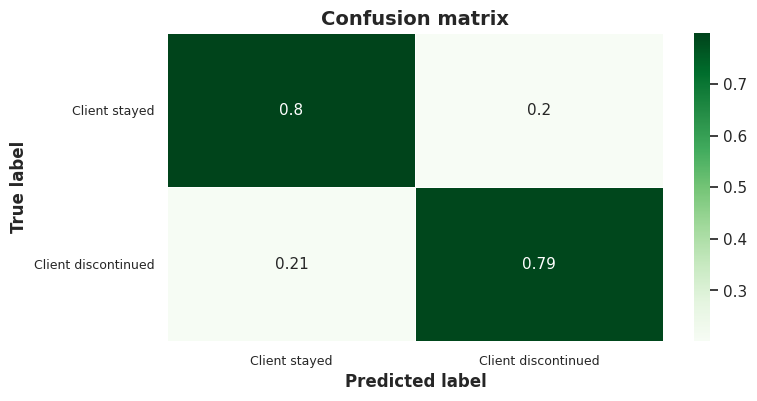

In [74]:
# Run build_confusion_matrix function to create confusion matrix
build_confusion_matrix(model_lgm, target_valid, predictions)

<b>Conclusions</b>

The gradient boosting model performed the best out of all 3 models, and its final performance in terms of AUC-ROC and accuarcy are nearly identical to that of the logistic regression base model. The final AUC-ROC of the optimized model was a <font color='red'><b>0.8641</font></b>. Therefore, the gradient boosting model was selected for model evaluation on the test dataset.

Twelve parameters were fine-tuned for their optimal values, but the four below were the final selections based on their impact on the final model outcome. The best values that resulted from the gridsearch object are also included.

- <mark>num_leaves</mark>: 127
- <mark>max_depth</mark>: 5
- <mark>n_estimators</mark>: 200
- <mark>learning_rate</mark>: 0.01

In [80]:
# Run build_table function to compare all models
build_table(auc_roc_lr, acc_lr, auc_roc_lgm_base, acc_lgm_base, auc_roc_lgm_opt, acc_lgm_opt)

AUC-ROC  Accuracy
Logistic regression   0.8648    0.7835
Unoptimized model     0.8471    0.7885
Optimized model       0.8641    0.7970

## Final model evaluation


AUC-ROC score: 0.8407
Accuracy score: 0.7509


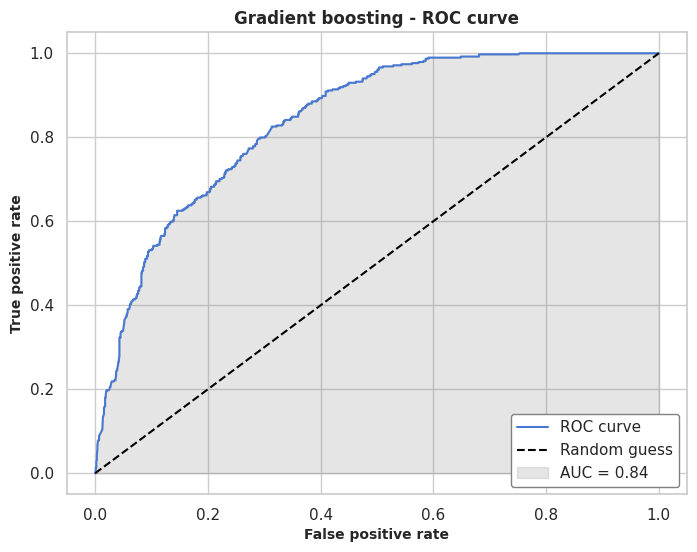

In [81]:
# Run build_model function to build model, gather predictions, and plot ROC curve
predictions, auc_roc_lgm_test, acc_lgm_test = build_model(model_lgm, features_test, target_test, 'Gradient boosting')

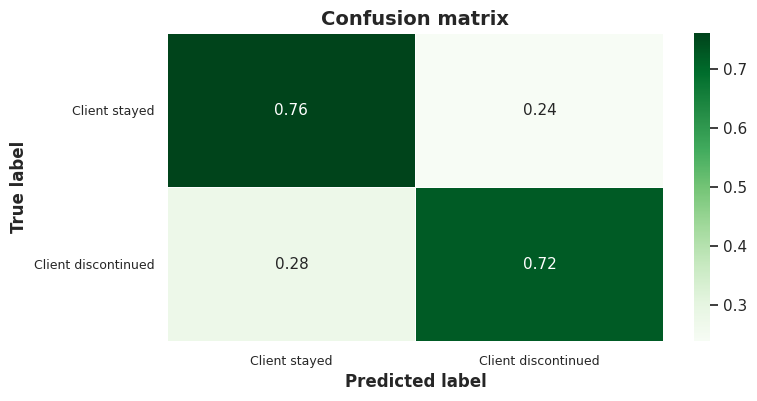

In [82]:
# Run build_confusion_matrix function to create confusion matrix
build_confusion_matrix(model_lgm, target_test, predictions)

<b>Conclusions</b>

The final model AUC-ROC and accuarcy scores for the test dataset were <font color='red'><b>0.8407</font></b> and <font color='red'><b>0.7509</font></b> respectively. The final scores are only a bit lower than what was yielded during model building and analysis, concluding that there is not overfitting in the model and it is still reliable in terms of making accurate predictions.

In [86]:
print('AUC-ROC:', auc_roc_lgm_test)
print('Accuracy:', acc_lgm_test)

AUC-ROC: 0.8407
Accuracy: 0.7509


# Conclusions

Interconnect requested for a better way to predict and forecast what clients may be discontiuing service. Knowing this upfront could allow them to target certain groups to then offer them promotional deals and special plan options in an attempt to prevent these groups of clients from leaving. Having a means to identify these groups allows them to be more proactive in keeping their business, rather than being reactive after it happens. 

Here is a review of the tasks that were prformed to create a model to successfully predict client churn for Interconnect.

- Data preprocessing tasks
    - Merged all datasets
    - Updated column formatting
    - Convertd data types for certain columns
- Exploratory data analysis
    - Client churn progression
    - Client tenure comparison
    - Client characteristics comparison (gender and seniority)
    - Internet services vs client churn
    - Contract length vs client churn
    - Charges vs client churn
- Feature engineering tasks
    - Created new target field called <b><mark>discontinued</mark></b>
    - Performed one-hot encoding
    - Performed standard scaling
- Model preparation
    - Defined features and target
    - Split data into training, validation, and test datasets
    - Performed upsampling to fix class imbalance
    - Built functions to streamline model building process
    - Created a logistic regression base model
- Model building and analysis
    - Random forest
    - K-nearest neighbors
    - Gradient boosting
- Final model evaluation

After building and fine-tuning models for all three model types, the gradient boosting model performed the best and was tested on the test dataset. The model yielded a AUC-ROC score <font color='red'><b>0.8407</font></b> which beats the threshold of <font color='red'><b>0.75</font></b>. Moreover, the performance of the model proves that it can adequately predict what clients could discontinue service, allowing Interconnect to perform actions quickly to try and keep their business.